# This notebook is for the purpose of model development

## Let's check to see that we can access CUDA GPU acceleration.

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

True
NVIDIA GeForce RTX 3080 Ti


## All good there. Let's now load our dataset.

In [5]:
# we need our custom class defined for pickle
class SyntheticEventDataset(torch.utils.data.Dataset):
    def __init__(self, csv_folder_path):
        pass
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

class CustomDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        data, target = self.original_dataset[idx]
        
        # Unsqueeze the feature tensor to add the last dimension
        data = data.unsqueeze(-1)  # Add dimension at the end to make it (27500, 1)
        
        # Extract only the first value from the target tensor (if necessary)
        target = target[0] if isinstance(target, torch.Tensor) and target.dim() > 0 else target
        
        return data, target

train_dataset_cm = torch.load('PyTorch_Synthetic_Data/train_data_cm.pt', weights_only=False)
val_dataset_cm = torch.load('PyTorch_Synthetic_Data/validation_data_cm.pt', weights_only=False)
test_dataset_cm = torch.load('PyTorch_Synthetic_Data/test_data_cm.pt', weights_only=False)

In [6]:
class SubsetDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, indices):
        self.original_dataset = original_dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.original_dataset[self.indices[idx]]

# Define the indices for the first 1000 elements
subset_indices = list(range(10000))

# Create a subset of train_dataset_cm
train_dataset_subset = SubsetDataset(train_dataset_cm, subset_indices)

## With the dataset read in, let's define some DataLoaders.

In [7]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(train_dataset_cm, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_cm, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset_cm, batch_size=batch_size, shuffle=False)
sub_loader = DataLoader(train_dataset_subset, batch_size=batch_size, shuffle=True)

# Here we can see that our data is loading correctly
X, y = next(iter(train_loader))
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([32, 27500, 1])
Target shape: torch.Size([32])


## Excellent, with the data handling steps in place we can move on to building the neural net.

In [2]:
import torch.nn as nn

class CustomModel(nn.Module):
    def __init__(self, input_size, lstm_hidden_units, dense_sizes, dropout_prob):
        super(CustomModel, self).__init__()
        
        # Initial convolutional layer with 8 out_channels, kernel size 64, linear activation
        self.conv1 = nn.Conv1d(
            in_channels=input_size,
            out_channels=8,
            kernel_size=64,
            stride=1,
            padding=32  # To keep the output size the same (valid padding)
        )
        self.conv1_activation = nn.Identity()  # Linear activation, no change
        
        # Convolutional layers with 8 out_channels, kernel size 32, ReLU activation
        self.conv2 = nn.Conv1d(
            in_channels=8,
            out_channels=8,
            kernel_size=32,
            stride=1,
            padding=16  # To keep output size the same
        )
        self.conv2_activation = nn.ReLU()
        
        self.conv3 = nn.Conv1d(
            in_channels=8,
            out_channels=8,
            kernel_size=32,
            stride=1,
            padding=16  # To keep output size the same
        )
        self.conv3_activation = nn.ReLU()
        
        # Flatten, Batch Normalization and Max Pooling layers
        self.flatten = nn.Flatten()
        self.batch_norm = nn.BatchNorm1d(8)
        self.max_pool = nn.MaxPool1d(kernel_size=3)
        
        # Repeating the 2 convolution + batch normalization + max pooling sequence
        self.conv4 = nn.Conv1d(
            in_channels=8,
            out_channels=8,
            kernel_size=32,
            stride=1,
            padding=16
        )
        self.conv4_activation = nn.ReLU()
        
        self.conv5 = nn.Conv1d(
            in_channels=8,
            out_channels=8,
            kernel_size=32,
            stride=1,
            padding=16
        )
        self.conv5_activation = nn.ReLU()
        
        # Second sequence of Batch Normalization and Max Pooling
        self.batch_norm2 = nn.BatchNorm1d(8)
        
        # Final convolution layer with 16 out_channels, kernel size 16, linear activation
        self.conv6 = nn.Conv1d(
            in_channels=8,
            out_channels=16,
            kernel_size=16,
            stride=2,
            padding=8  # To keep output size the same
        )
        self.conv6_activation = nn.Identity()  # Linear activation, no change
        
        # Max Pooling after the last convolution
        self.max_pool2 = nn.MaxPool1d(kernel_size=3)
        
        # Bi-directional LSTM layer with 8 hidden units
        self.lstm = nn.LSTM(
            input_size=16,  # The output of the last conv layer (16 channels)
            hidden_size=lstm_hidden_units,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )
        
        # Flatten after LSTM and fully connected layers with decreasing size
        self.fc1 = nn.Linear(lstm_hidden_units * 2, dense_sizes[0])  # *2 for bidirectional
        self.fc2 = nn.Linear(dense_sizes[0], dense_sizes[1])
        self.fc3 = nn.Linear(dense_sizes[1], dense_sizes[2])
        self.fc4 = nn.Linear(dense_sizes[2], dense_sizes[3])
        self.output = nn.Linear(dense_sizes[3], 1)  # Output single feature
        
        # ReLU activations for dense layers (except the last one)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        # Ensure the input shape is [batch_size, in_channels, seq_length]
        x = x.transpose(1, 2)  # [batch_size, 1, seq_length]
        
        # Initial convolution and activation
        x = self.conv1(x)
        x = self.conv1_activation(x)  # Linear, no activation change
        
        # First set of convolutions with ReLU activations
        x = self.conv2(x)
        x = self.conv2_activation(x)
        x = self.conv3(x)
        x = self.conv3_activation(x)
        
        # Batch normalization and max pooling
        x = self.max_pool(x)
        x = self.batch_norm(x)
        
        # Second set of convolutions with ReLU activations
        x = self.conv4(x)
        x = self.conv4_activation(x)
        x = self.conv5(x)
        x = self.conv5_activation(x)
        
        # Batch normalization and max pooling
        x = self.max_pool(x)
        x = self.batch_norm2(x)
        
        # Final convolution with linear activation and max pooling
        x = self.conv6(x)
        x = self.conv6_activation(x)  # Linear, no activation change
        x = self.max_pool2(x)
        
        # Prepare data for LSTM: reshape to [batch_size, seq_len, input_size]
        x = x.transpose(1, 2)  # LSTM expects [batch_size, seq_len, input_size]
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Get the last hidden state (forward and backward for bidirectional)
        last_hidden_state = torch.cat((h_n[-2], h_n[-1]), dim=1)  # Shape: (batch_size, hidden_size * 2)
        
        # Dense layers with ReLU activations and dropout
        x = self.relu(self.fc1(last_hidden_state))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)  # No activation after the last dense layer
        
        # Output layer: final single value prediction
        output = self.output(x)  # Shape: (batch_size, 1)
        output = output.squeeze(1)
        return output

# Example initialization
model = CustomModel(
    input_size=1,                # Feature size (e.g., raw strain data per timestep) 
    lstm_hidden_units=8,         # LSTM hidden units
    dense_sizes=[64, 32, 16, 8], # Sizes of the tapering dense layers
    dropout_prob=0.05            # Dropout probability
)

print(model)
print(f"Num of params:{sum(p.numel() for p in model.parameters())}")

CustomModel(
  (conv1): Conv1d(1, 8, kernel_size=(64,), stride=(1,), padding=(32,))
  (conv1_activation): Identity()
  (conv2): Conv1d(8, 8, kernel_size=(32,), stride=(1,), padding=(16,))
  (conv2_activation): ReLU()
  (conv3): Conv1d(8, 8, kernel_size=(32,), stride=(1,), padding=(16,))
  (conv3_activation): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (batch_norm): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(8, 8, kernel_size=(32,), stride=(1,), padding=(16,))
  (conv4_activation): ReLU()
  (conv5): Conv1d(8, 8, kernel_size=(32,), stride=(1,), padding=(16,))
  (conv5_activation): ReLU()
  (batch_norm2): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv1d(8, 16, kernel_size=(16,), stride=(2,), padding=(8,))
  (conv6_activation): Identity()
  (max_pool2): MaxPool1d(kernel_size=3, stride=3, pad

## Define the hyper parameters for our model

In [7]:
learning_rate = 1e-5

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Define the training and validation loop

In [8]:
import time
from tqdm import tqdm

def train_model(data_loader, model, loss_function, optimizer, device="cuda"):
    """
    Train the model for one epoch.

    Args:
        data_loader (DataLoader): DataLoader for the training data.
        model (nn.Module): The PyTorch model to train.
        loss_function (nn.Module): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        device (str): Device to use ('cpu' or 'cuda').
    """
    model.train()
    total_loss = 0
    num_batches = len(data_loader)

    progress_bar = tqdm(data_loader, desc="Training", leave=False)

    for X, y in progress_bar:
        # Move data and target to the specified device
        X, y = X.to(device), y.to(device)

        # Forward pass
        output = model(X)
        loss = loss_function(output, y)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss
        total_loss += loss.item()

        # Update progress bar with the current loss
        progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / num_batches
    #print(f"Train loss: {avg_loss:.4f}")
    return avg_loss

def validate_model(data_loader, model, loss_function, device="cuda"):
    """
    Evaluate the model on the test/validation data.

    Args:
        data_loader (DataLoader): DataLoader for the test/validation data.
        model (nn.Module): The PyTorch model to evaluate.
        loss_function (nn.Module): The loss function.
        device (str): Device to use ('cpu' or 'cuda').
    """
    model.eval()
    total_loss = 0
    num_batches = len(data_loader)

    progress_bar = tqdm(data_loader, desc="Validating", leave=False)

    with torch.no_grad():
        for X, y in progress_bar:
            # Move data and target to the specified device
            X, y = X.to(device), y.to(device)

            # Forward pass
            output = model(X)
            loss = loss_function(output, y)

            # Track loss
            total_loss += loss.item()

            # Update progress bar with the current loss
            progress_bar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = total_loss / num_batches
    #print(f"Validation loss: {avg_loss:.4f}")
    return avg_loss

Epoch 0
---------


Train Loss: 2066.8295 -|- Validation Loss: 1989.5709 -|- Epoch Time: 41.9646 seconds


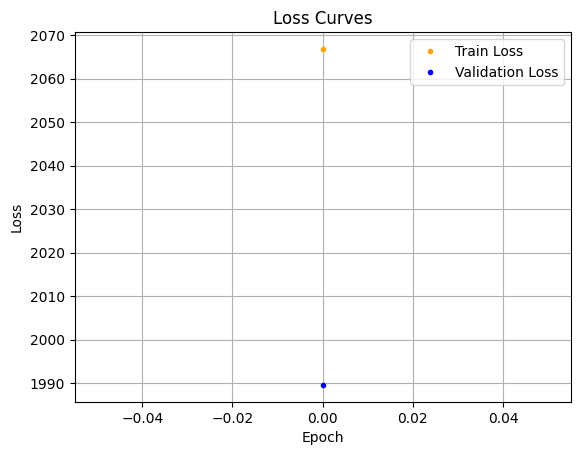


Epoch 1
---------


Train Loss: 1715.7532 -|- Validation Loss: 1287.0533 -|- Epoch Time: 41.7979 seconds


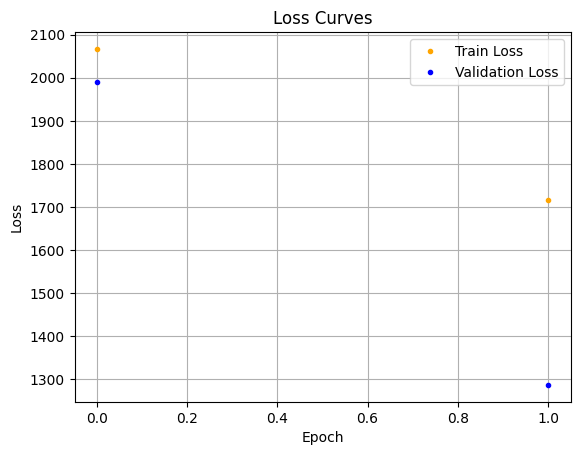


Epoch 2
---------


Train Loss: 777.1071 -|- Validation Loss: 344.0174 -|- Epoch Time: 42.0945 seconds


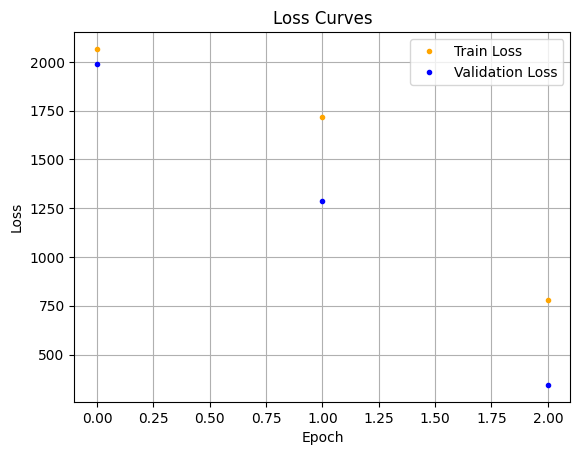


Epoch 3
---------


Train Loss: 184.0067 -|- Validation Loss: 76.3988 -|- Epoch Time: 42.2257 seconds


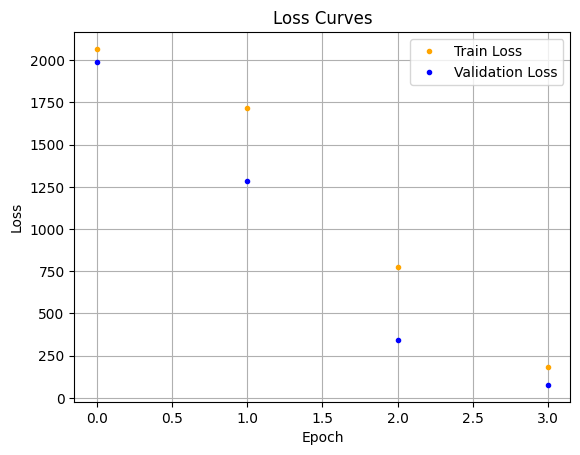


Epoch 4
---------


Train Loss: 81.2358 -|- Validation Loss: 40.8871 -|- Epoch Time: 42.2204 seconds


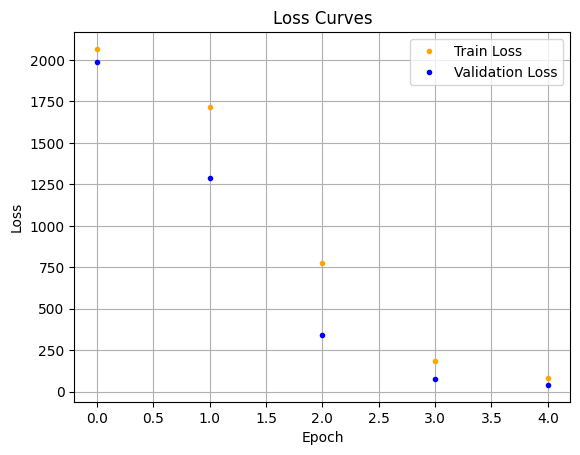


Epoch 5
---------


Train Loss: 64.7523 -|- Validation Loss: 34.1768 -|- Epoch Time: 42.1931 seconds


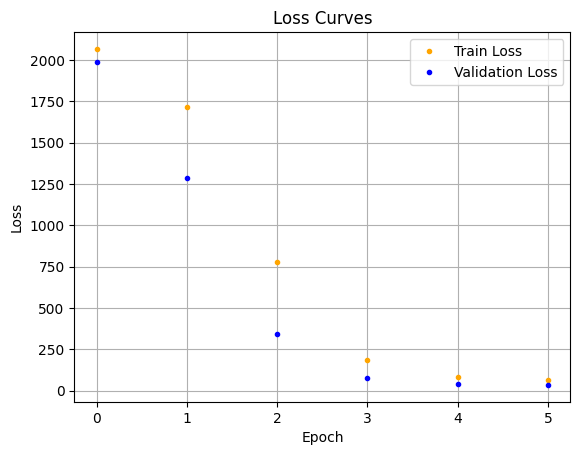


Epoch 6
---------


Train Loss: 59.6028 -|- Validation Loss: 31.7352 -|- Epoch Time: 42.2634 seconds


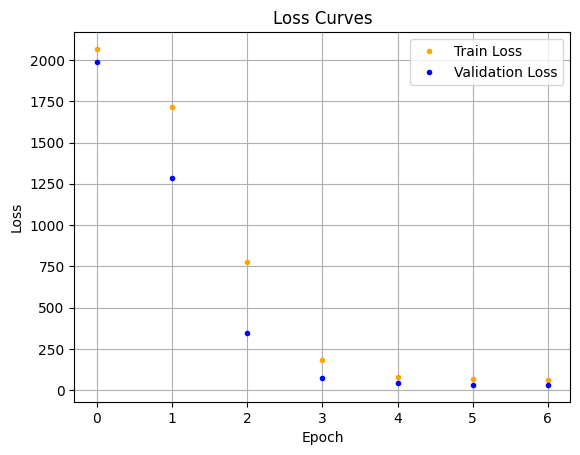


Epoch 7
---------


Train Loss: 57.7194 -|- Validation Loss: 30.0679 -|- Epoch Time: 42.3008 seconds


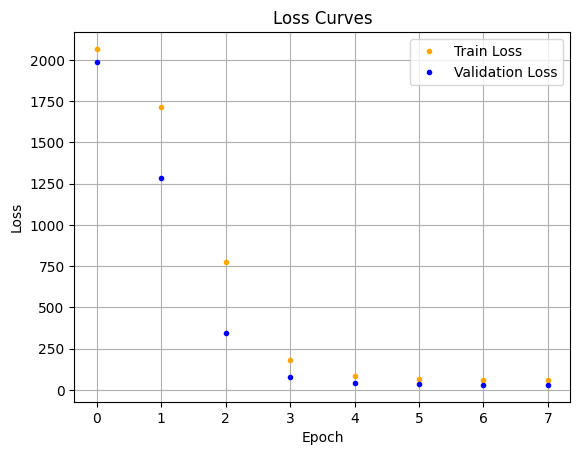


Epoch 8
---------


Train Loss: 55.5323 -|- Validation Loss: 28.6184 -|- Epoch Time: 42.3741 seconds


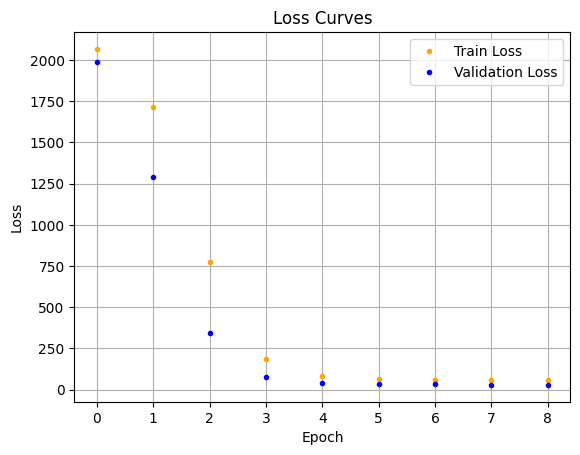


Epoch 9
---------


Train Loss: 53.7062 -|- Validation Loss: 27.4675 -|- Epoch Time: 42.2081 seconds


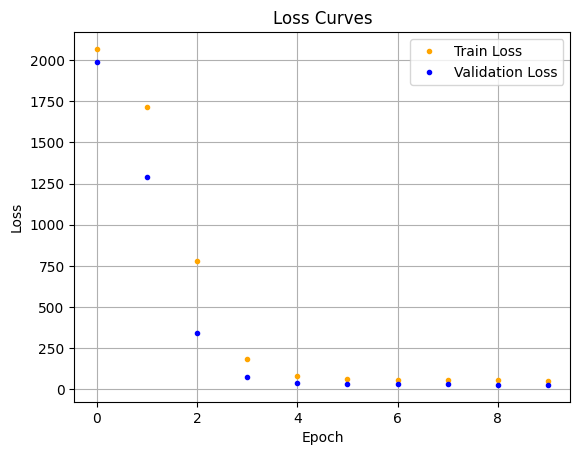


Epoch 10
---------


Train Loss: 52.6162 -|- Validation Loss: 26.6561 -|- Epoch Time: 42.2039 seconds


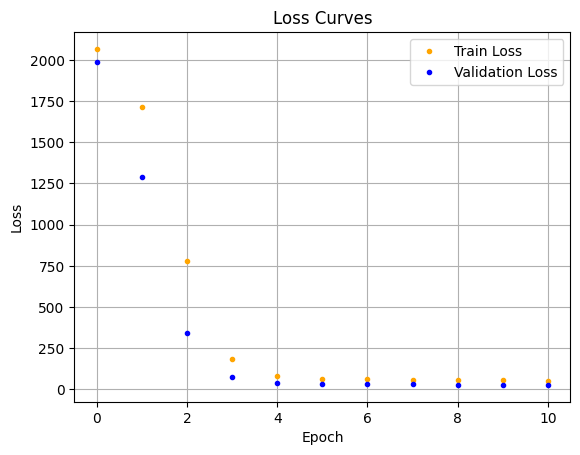


Epoch 11
---------


Train Loss: 51.3534 -|- Validation Loss: 25.1356 -|- Epoch Time: 42.2308 seconds


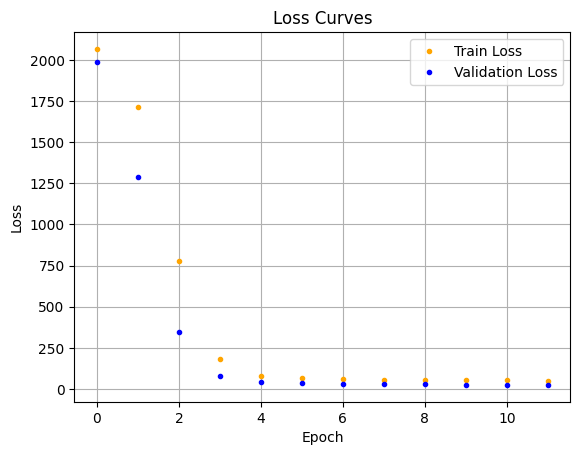


Epoch 12
---------


Train Loss: 49.8957 -|- Validation Loss: 24.5636 -|- Epoch Time: 42.1974 seconds


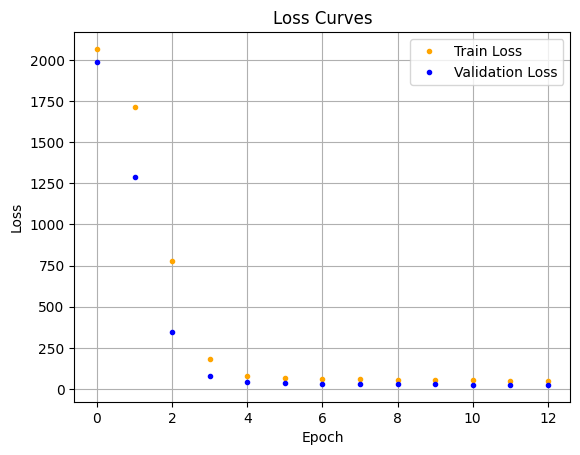


Epoch 13
---------


Train Loss: 49.7622 -|- Validation Loss: 24.6720 -|- Epoch Time: 41.5367 seconds


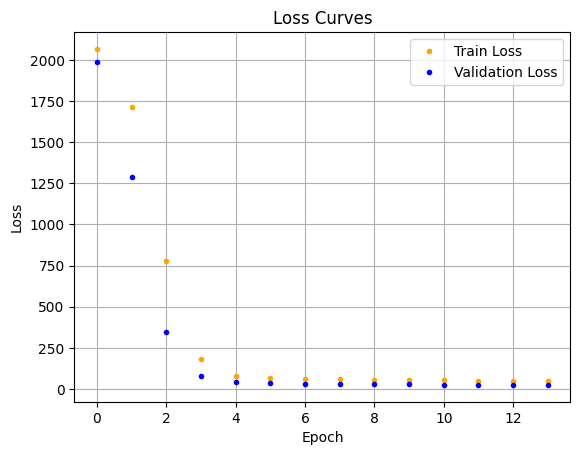


Epoch 14
---------


Train Loss: 48.5558 -|- Validation Loss: 24.2844 -|- Epoch Time: 41.5133 seconds


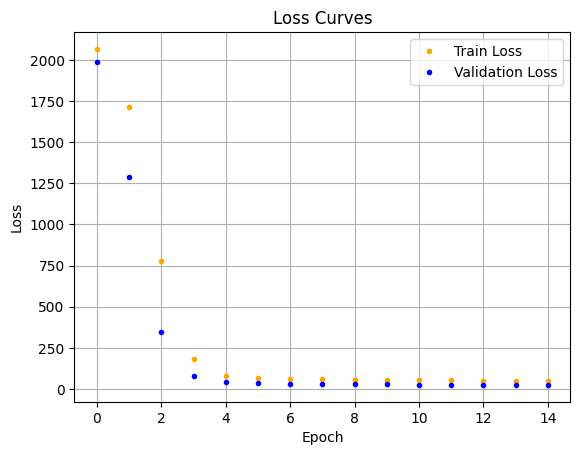


Epoch 15
---------


Train Loss: 47.9409 -|- Validation Loss: 23.1368 -|- Epoch Time: 41.5426 seconds


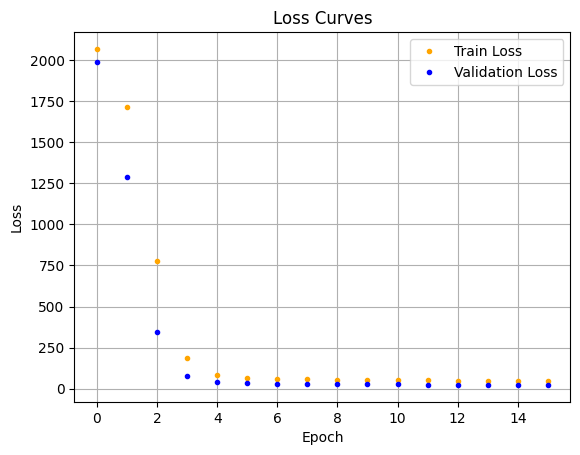


Epoch 16
---------


Train Loss: 47.2565 -|- Validation Loss: 22.6560 -|- Epoch Time: 41.4983 seconds


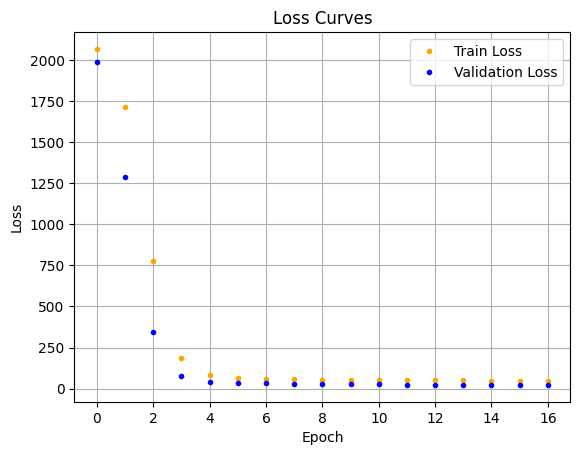


Epoch 17
---------


Train Loss: 47.1089 -|- Validation Loss: 22.8593 -|- Epoch Time: 41.6390 seconds


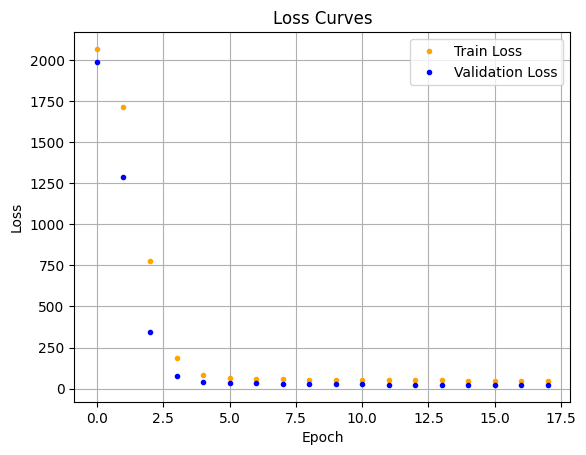


Epoch 18
---------


Train Loss: 46.6343 -|- Validation Loss: 23.3307 -|- Epoch Time: 41.6458 seconds


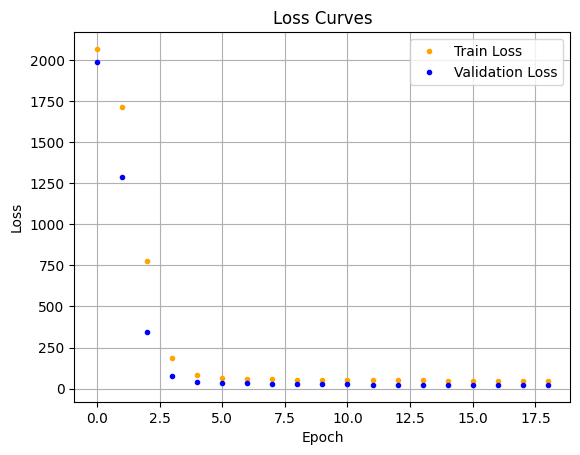


Epoch 19
---------


Train Loss: 46.4478 -|- Validation Loss: 21.9725 -|- Epoch Time: 41.6277 seconds


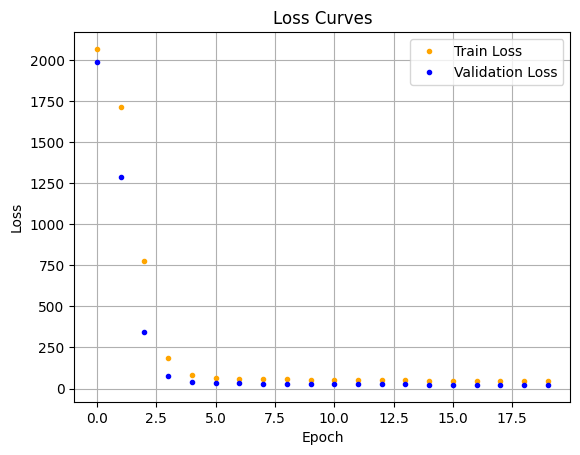


Epoch 20
---------


Train Loss: 45.9475 -|- Validation Loss: 22.2318 -|- Epoch Time: 41.6963 seconds


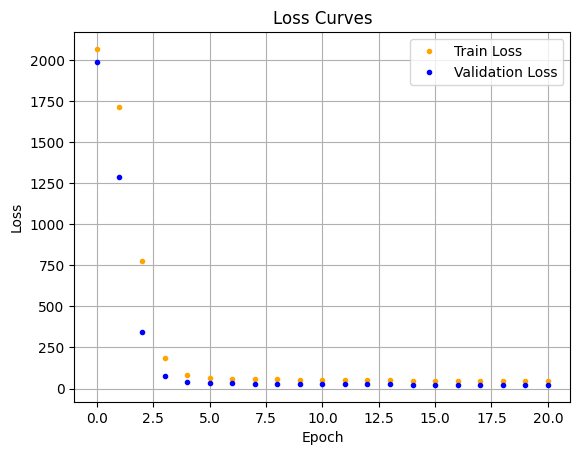


Epoch 21
---------


Train Loss: 45.5191 -|- Validation Loss: 21.7903 -|- Epoch Time: 41.6713 seconds


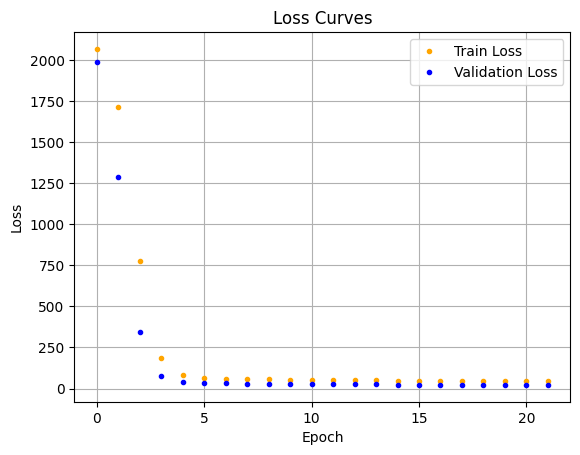


Epoch 22
---------


Train Loss: 45.4326 -|- Validation Loss: 21.4079 -|- Epoch Time: 41.6870 seconds


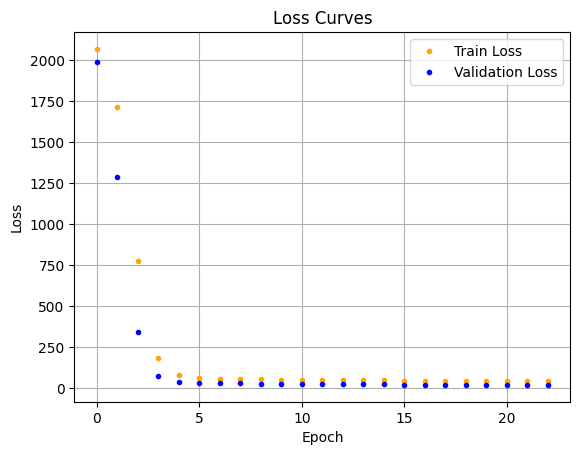


Epoch 23
---------


Train Loss: 44.7894 -|- Validation Loss: 21.1452 -|- Epoch Time: 41.7182 seconds


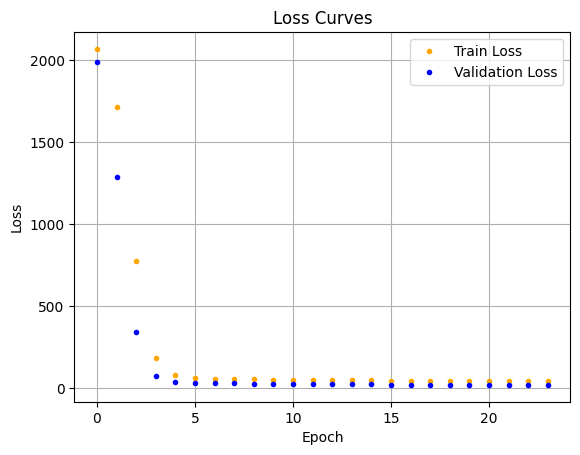


Epoch 24
---------


Train Loss: 44.8792 -|- Validation Loss: 20.9294 -|- Epoch Time: 41.7257 seconds


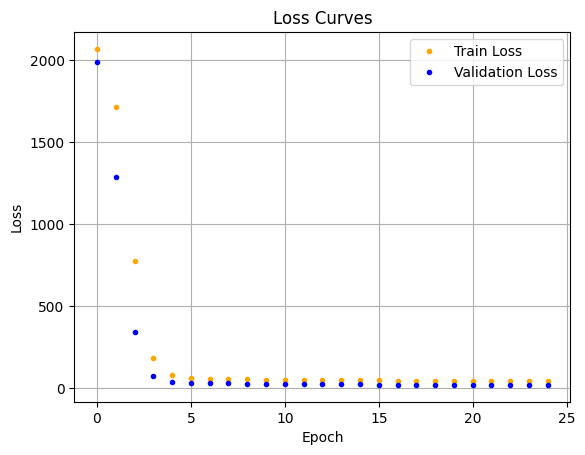


Epoch 25
---------


Train Loss: 44.2938 -|- Validation Loss: 21.4723 -|- Epoch Time: 41.6814 seconds


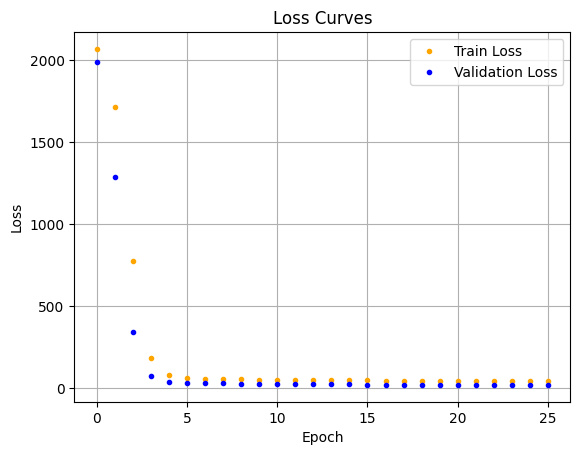


Epoch 26
---------


Train Loss: 44.4560 -|- Validation Loss: 20.8656 -|- Epoch Time: 41.6757 seconds


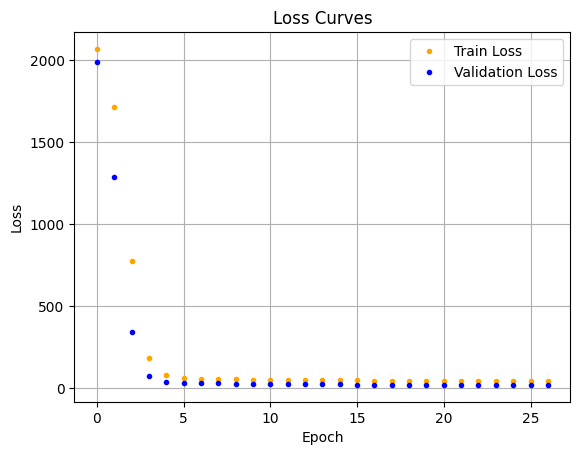


Epoch 27
---------


Train Loss: 43.4997 -|- Validation Loss: 20.7586 -|- Epoch Time: 41.6939 seconds


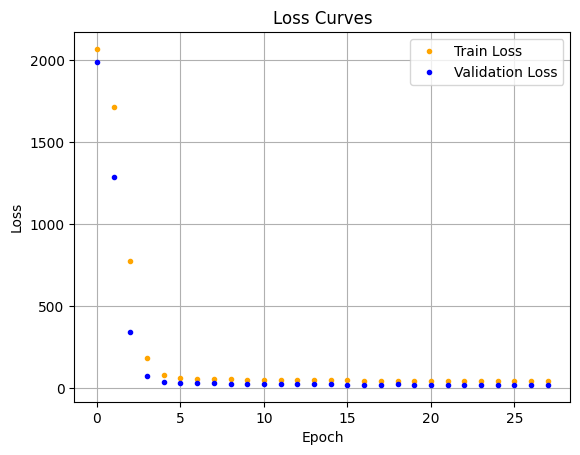


Epoch 28
---------


Train Loss: 43.6455 -|- Validation Loss: 20.4886 -|- Epoch Time: 41.6852 seconds


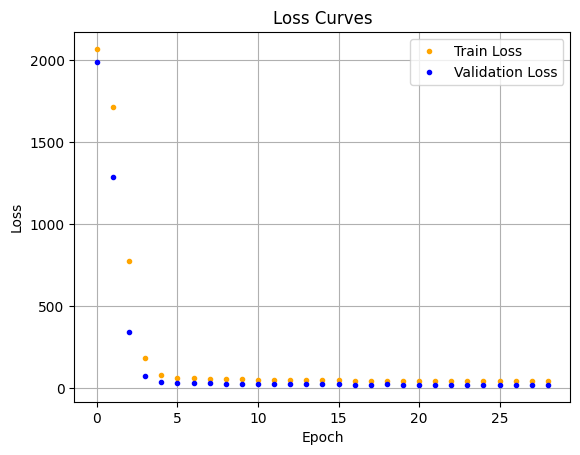


Epoch 29
---------


Train Loss: 42.7513 -|- Validation Loss: 20.8867 -|- Epoch Time: 41.6764 seconds


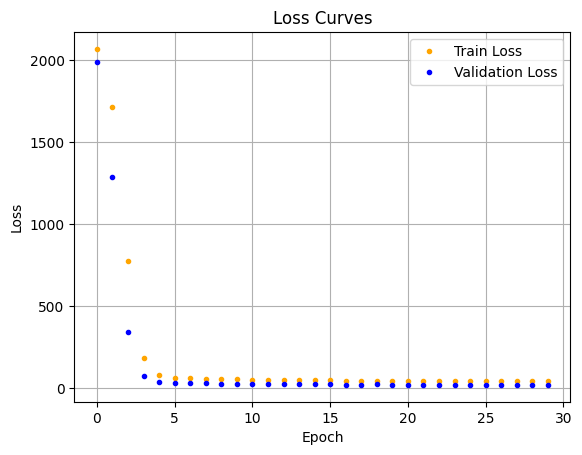


Epoch 30
---------


Train Loss: 42.8040 -|- Validation Loss: 20.2811 -|- Epoch Time: 41.7226 seconds


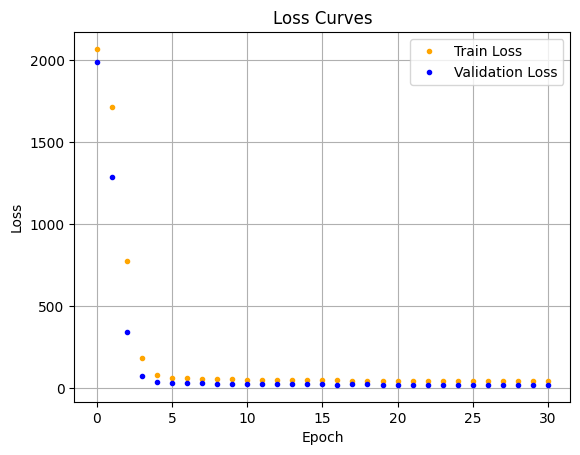


Epoch 31
---------


Train Loss: 43.0706 -|- Validation Loss: 20.0812 -|- Epoch Time: 41.6702 seconds


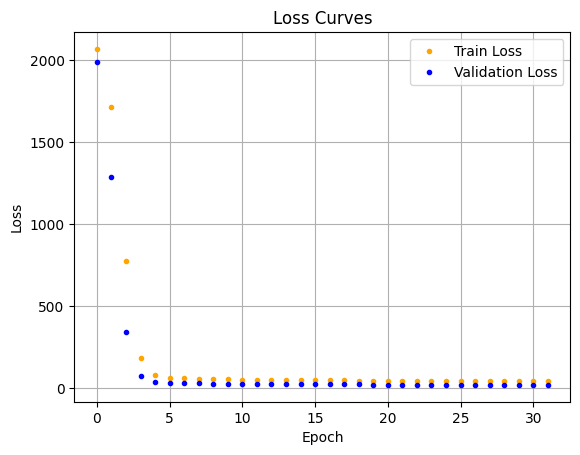


Epoch 32
---------


Train Loss: 42.8637 -|- Validation Loss: 20.7524 -|- Epoch Time: 41.6730 seconds


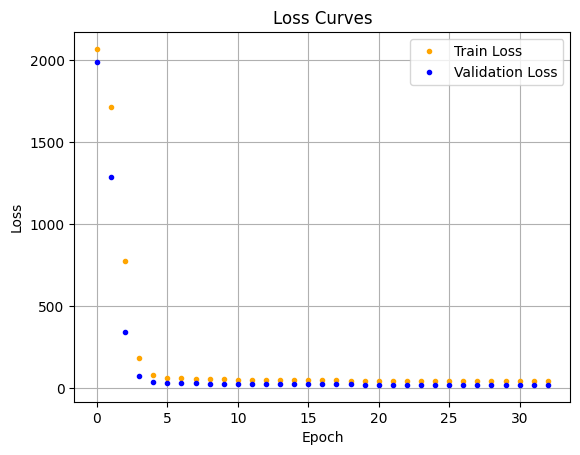


Epoch 33
---------


Train Loss: 42.3855 -|- Validation Loss: 19.9932 -|- Epoch Time: 41.6649 seconds


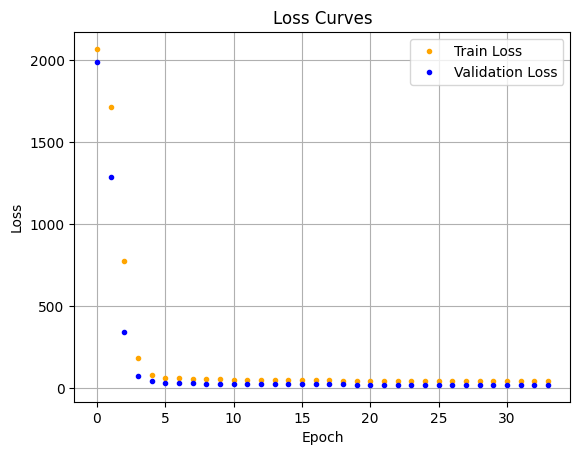


Epoch 34
---------


Train Loss: 41.9864 -|- Validation Loss: 19.7648 -|- Epoch Time: 41.6684 seconds


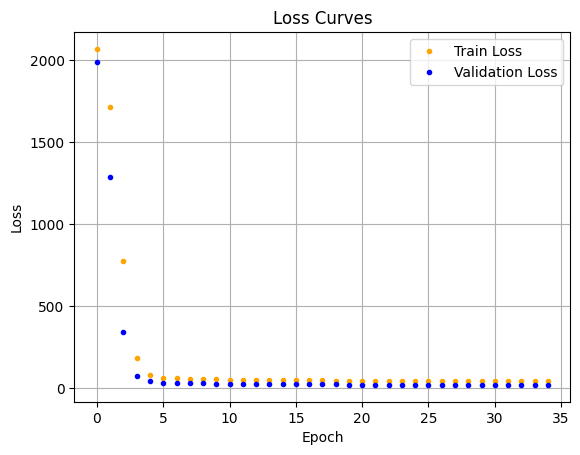


Epoch 35
---------


Train Loss: 42.4297 -|- Validation Loss: 21.4682 -|- Epoch Time: 41.6640 seconds


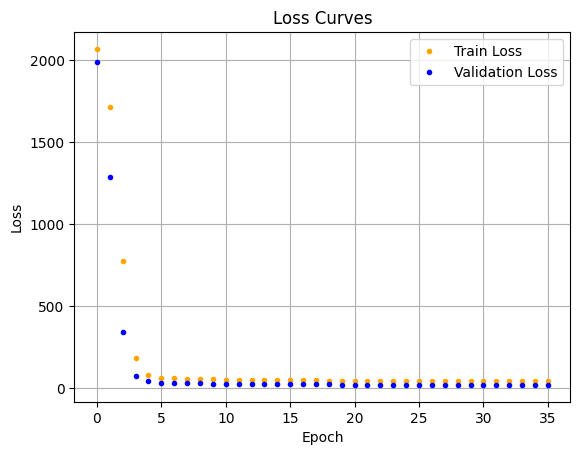


Epoch 36
---------


Train Loss: 41.9444 -|- Validation Loss: 20.1638 -|- Epoch Time: 41.6709 seconds


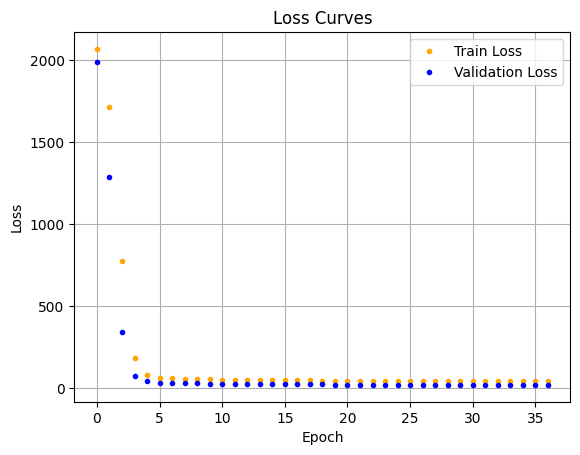


Epoch 37
---------


Train Loss: 41.8348 -|- Validation Loss: 19.7233 -|- Epoch Time: 41.6638 seconds


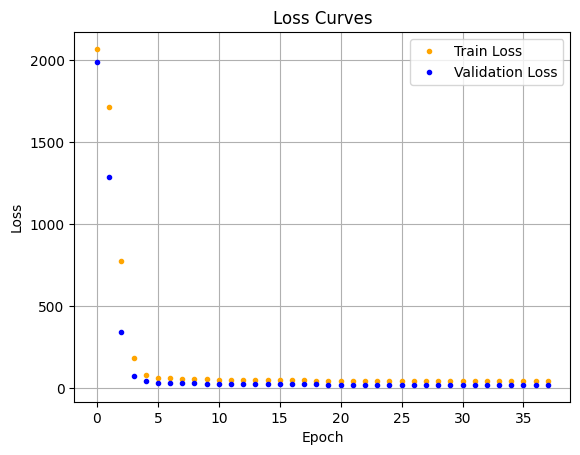


Epoch 38
---------


Train Loss: 41.5593 -|- Validation Loss: 19.9793 -|- Epoch Time: 41.6847 seconds


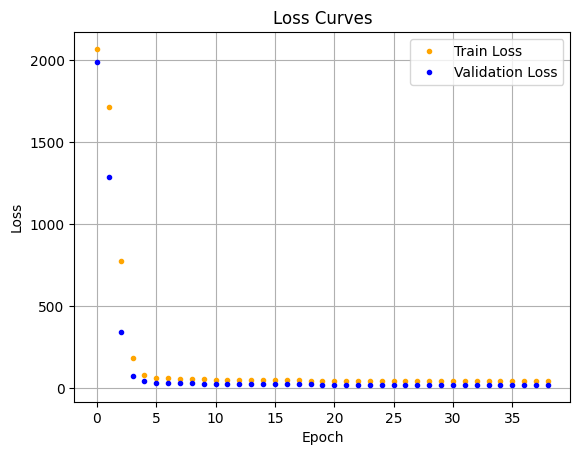


Epoch 39
---------


Train Loss: 41.1828 -|- Validation Loss: 19.8566 -|- Epoch Time: 41.6772 seconds


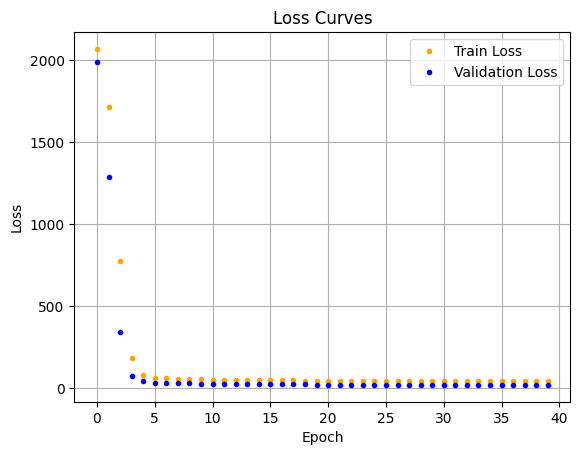


Epoch 40
---------


Train Loss: 40.9408 -|- Validation Loss: 19.5018 -|- Epoch Time: 41.6807 seconds


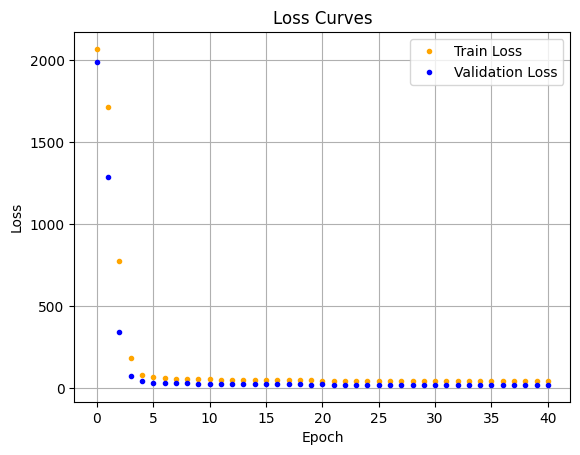


Epoch 41
---------


Train Loss: 41.4093 -|- Validation Loss: 19.7995 -|- Epoch Time: 41.6868 seconds


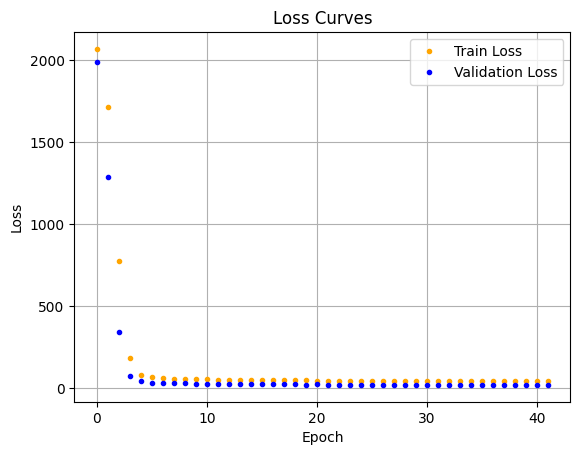


Epoch 42
---------


Train Loss: 41.2450 -|- Validation Loss: 19.5176 -|- Epoch Time: 41.7044 seconds


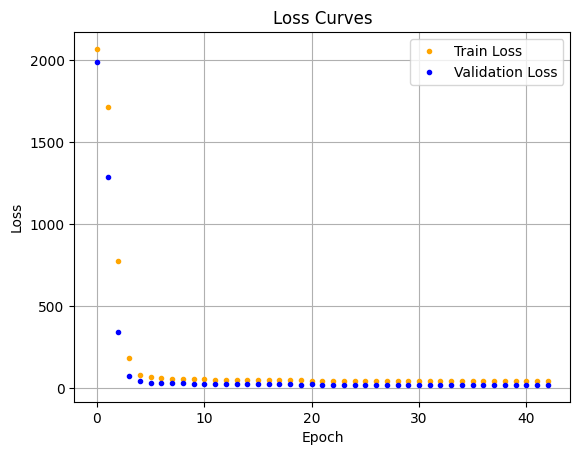


Epoch 43
---------


Train Loss: 40.7575 -|- Validation Loss: 19.6529 -|- Epoch Time: 41.7110 seconds


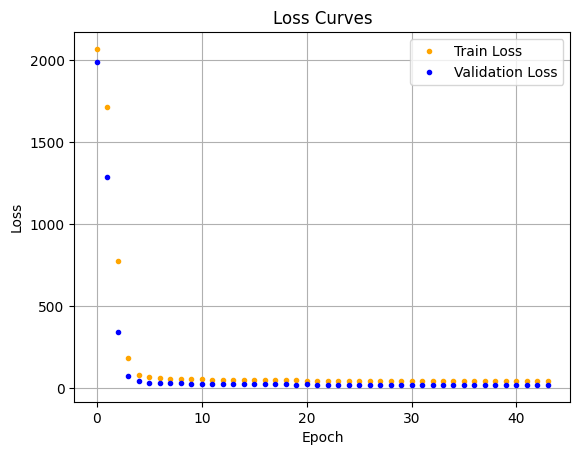


Epoch 44
---------


Train Loss: 40.5057 -|- Validation Loss: 19.8649 -|- Epoch Time: 41.7116 seconds


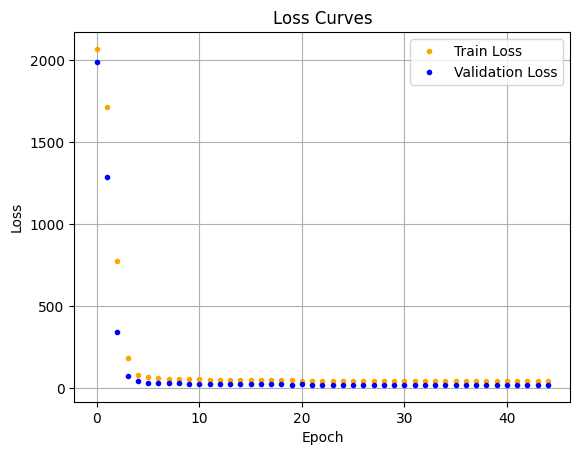


Epoch 45
---------


Train Loss: 40.4711 -|- Validation Loss: 19.1074 -|- Epoch Time: 41.7073 seconds


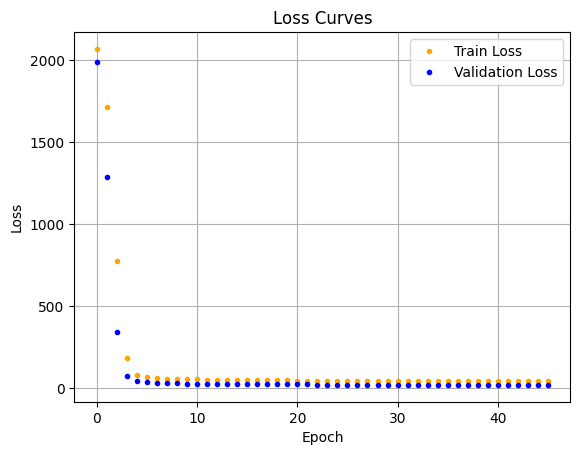


Epoch 46
---------


Train Loss: 40.4163 -|- Validation Loss: 19.3385 -|- Epoch Time: 41.7083 seconds


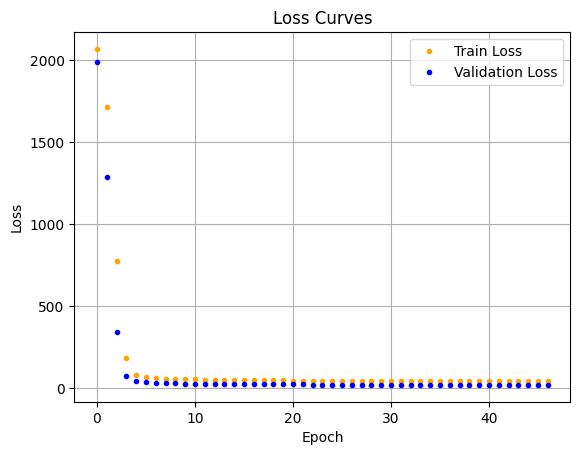


Epoch 47
---------


Train Loss: 40.2566 -|- Validation Loss: 19.0378 -|- Epoch Time: 41.7178 seconds


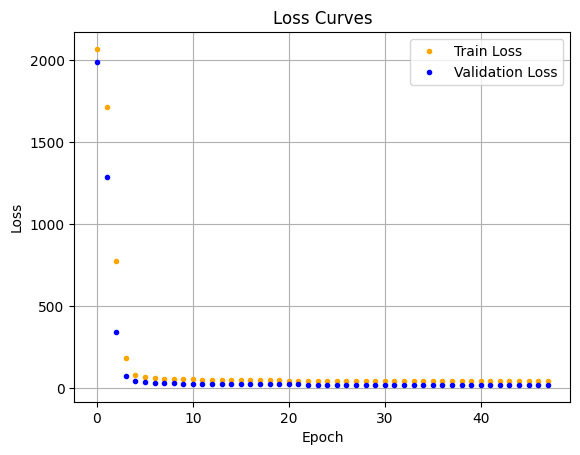


Epoch 48
---------


Train Loss: 39.6067 -|- Validation Loss: 19.8952 -|- Epoch Time: 41.7193 seconds


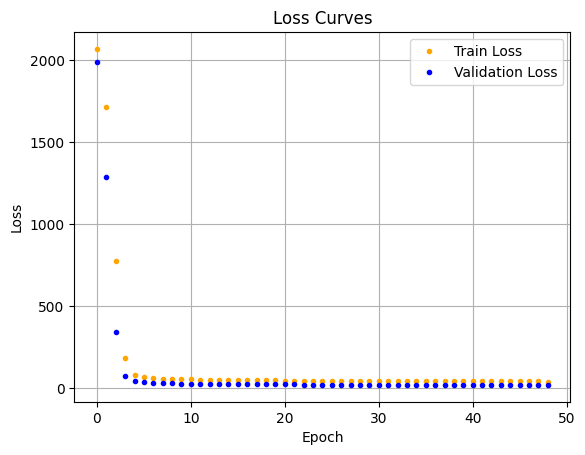


Epoch 49
---------


Train Loss: 39.6134 -|- Validation Loss: 19.2029 -|- Epoch Time: 41.7322 seconds


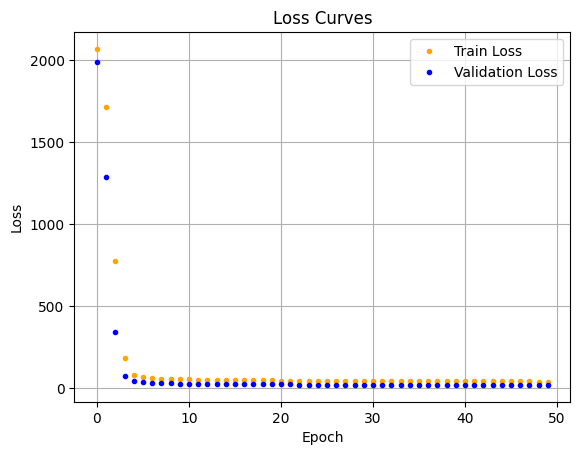


Epoch 50
---------


Train Loss: 39.3484 -|- Validation Loss: 19.2432 -|- Epoch Time: 41.7194 seconds


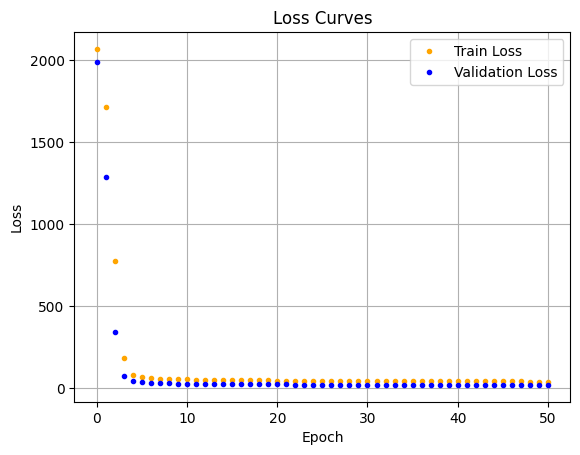


Epoch 51
---------


Train Loss: 39.3213 -|- Validation Loss: 19.6693 -|- Epoch Time: 41.7219 seconds


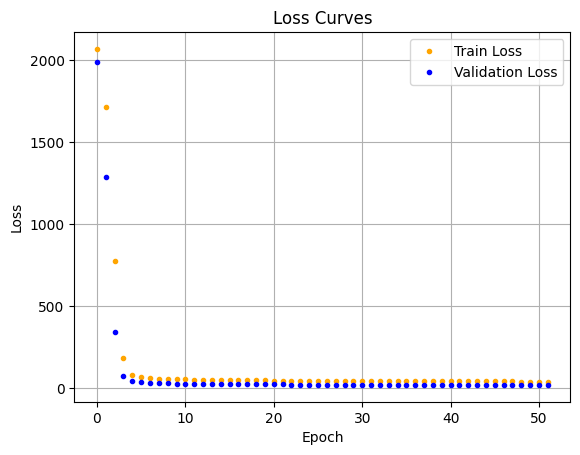


Epoch 52
---------


Train Loss: 39.2157 -|- Validation Loss: 19.8089 -|- Epoch Time: 41.7283 seconds


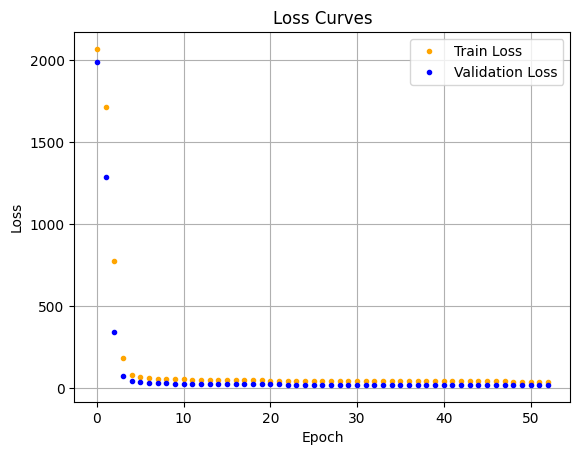


Epoch 53
---------


Train Loss: 39.2169 -|- Validation Loss: 19.5216 -|- Epoch Time: 41.7340 seconds


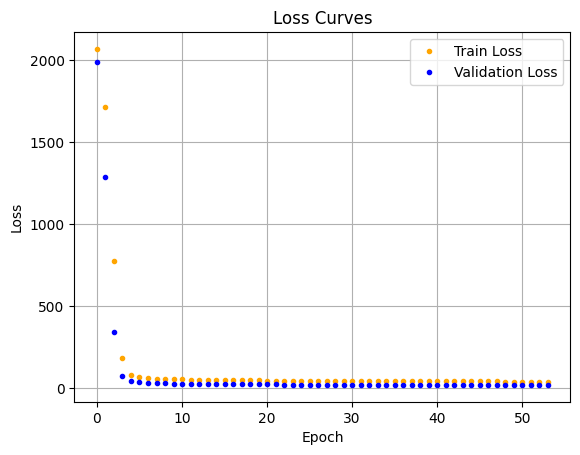


Epoch 54
---------


Train Loss: 38.9972 -|- Validation Loss: 18.9792 -|- Epoch Time: 41.7686 seconds


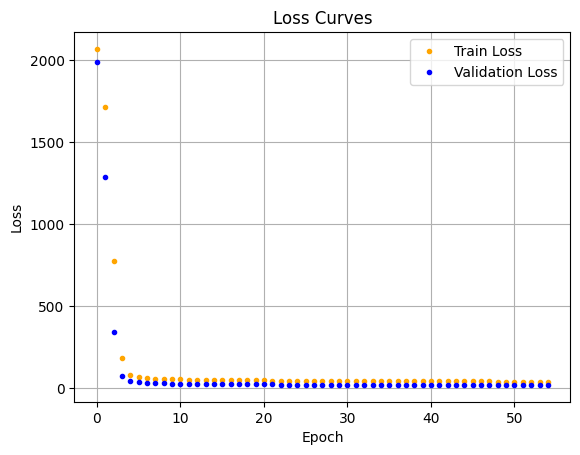


Epoch 55
---------


Train Loss: 38.8383 -|- Validation Loss: 18.7383 -|- Epoch Time: 41.6933 seconds


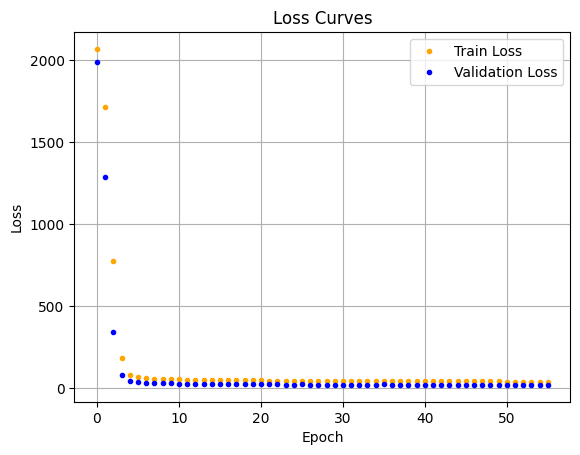


Epoch 56
---------


Train Loss: 38.3604 -|- Validation Loss: 18.8422 -|- Epoch Time: 41.7344 seconds


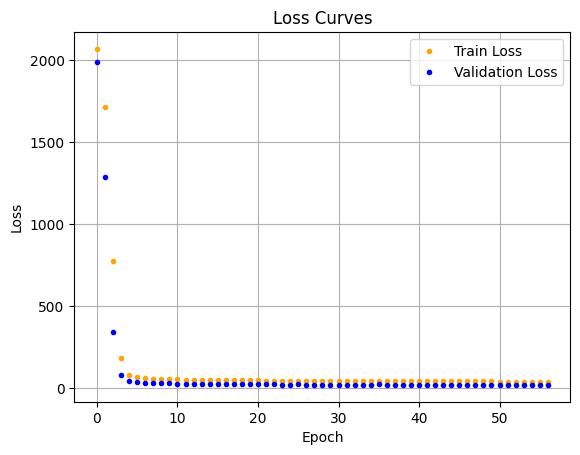


Epoch 57
---------


Train Loss: 38.2834 -|- Validation Loss: 19.1361 -|- Epoch Time: 41.7500 seconds


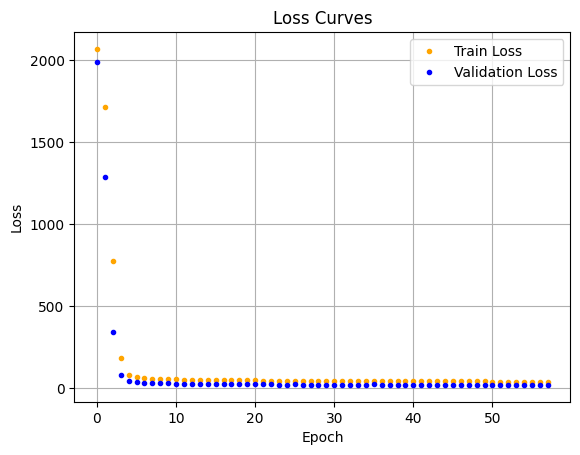


Epoch 58
---------


Train Loss: 38.3167 -|- Validation Loss: 18.9529 -|- Epoch Time: 41.7517 seconds


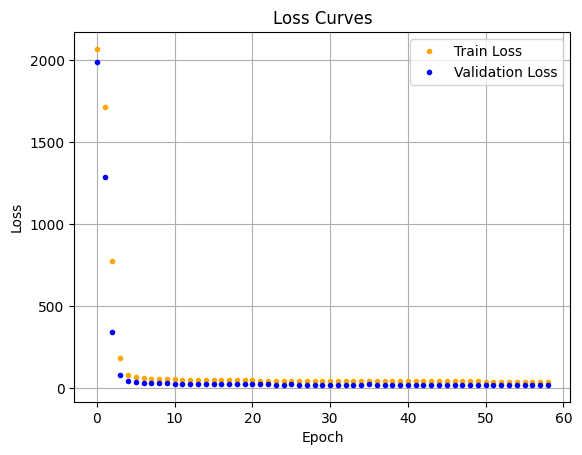


Epoch 59
---------


Train Loss: 38.0885 -|- Validation Loss: 19.1845 -|- Epoch Time: 41.7403 seconds


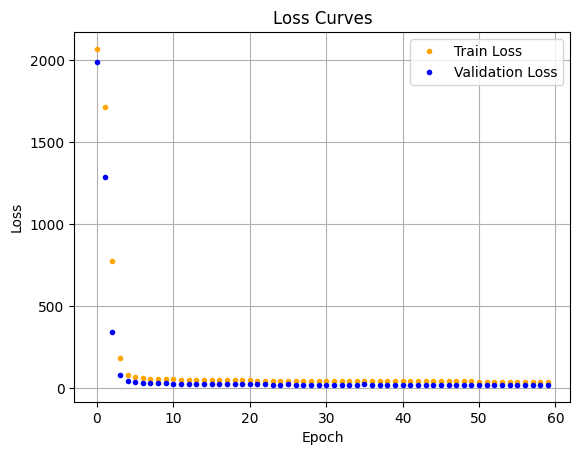


Epoch 60
---------


Train Loss: 37.7106 -|- Validation Loss: 19.2943 -|- Epoch Time: 41.7368 seconds


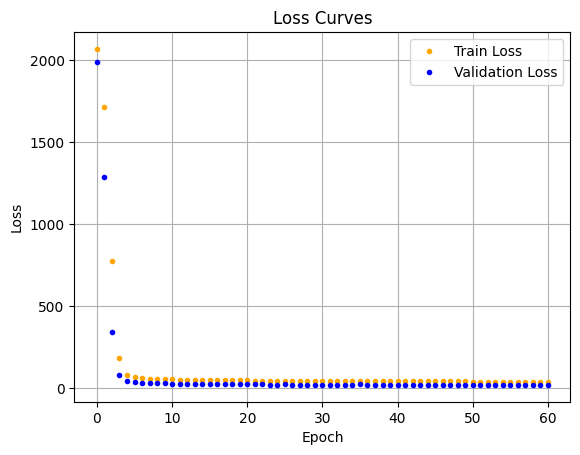


Epoch 61
---------


Train Loss: 37.6359 -|- Validation Loss: 19.6737 -|- Epoch Time: 41.7241 seconds


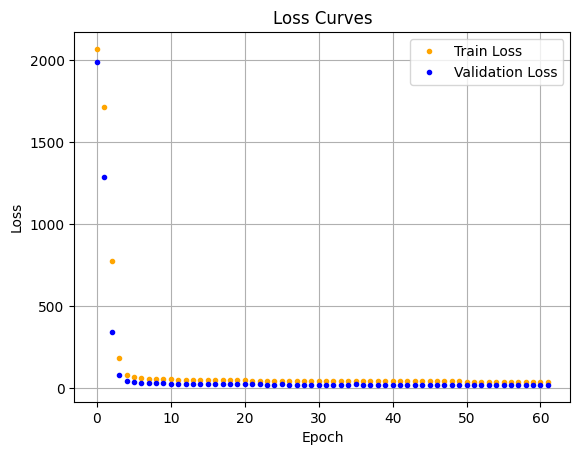


Epoch 62
---------


Train Loss: 37.4719 -|- Validation Loss: 18.8437 -|- Epoch Time: 41.7255 seconds


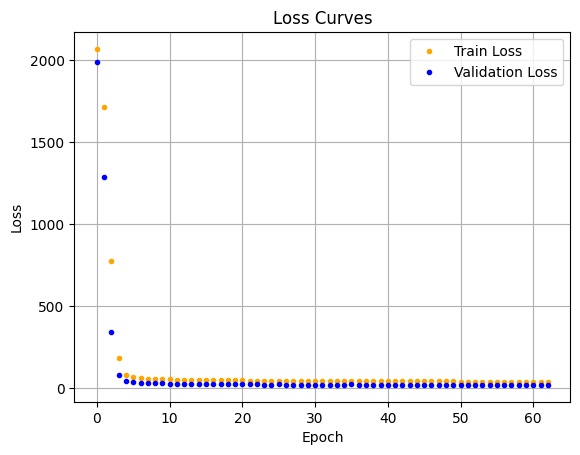


Epoch 63
---------


Train Loss: 37.5987 -|- Validation Loss: 18.5637 -|- Epoch Time: 41.7037 seconds


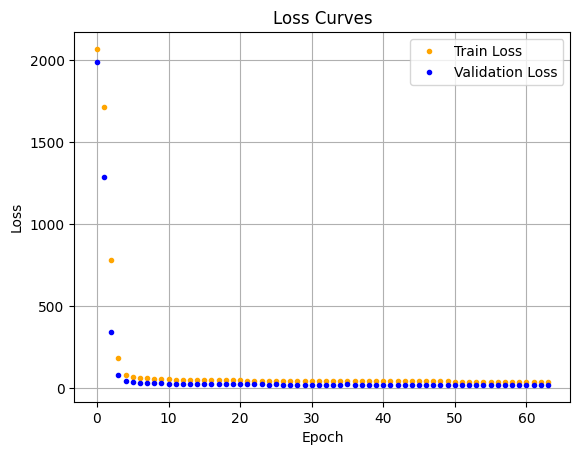


Epoch 64
---------


Train Loss: 37.4314 -|- Validation Loss: 18.8126 -|- Epoch Time: 41.7315 seconds


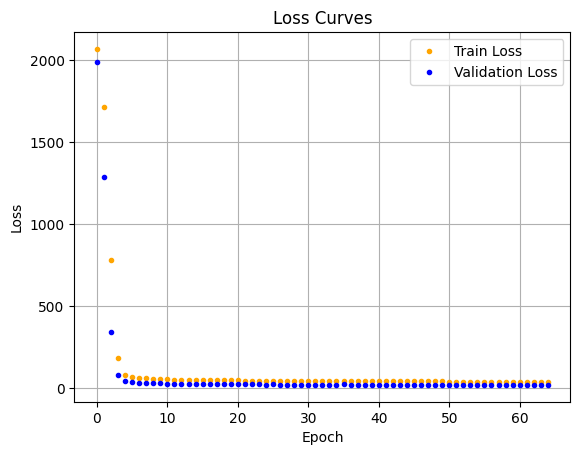


Epoch 65
---------


Train Loss: 37.0158 -|- Validation Loss: 18.7024 -|- Epoch Time: 41.7230 seconds


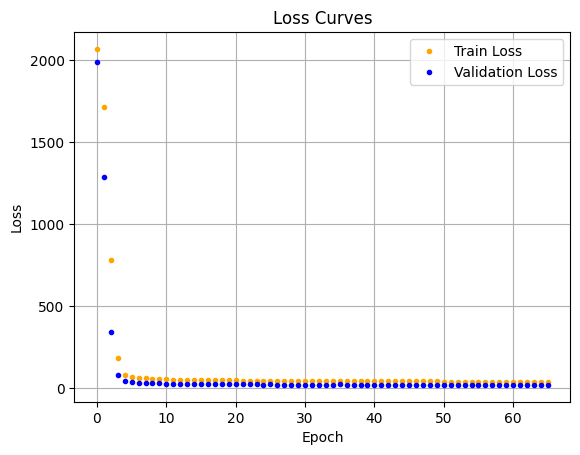


Epoch 66
---------


Train Loss: 37.2312 -|- Validation Loss: 20.0181 -|- Epoch Time: 41.7128 seconds


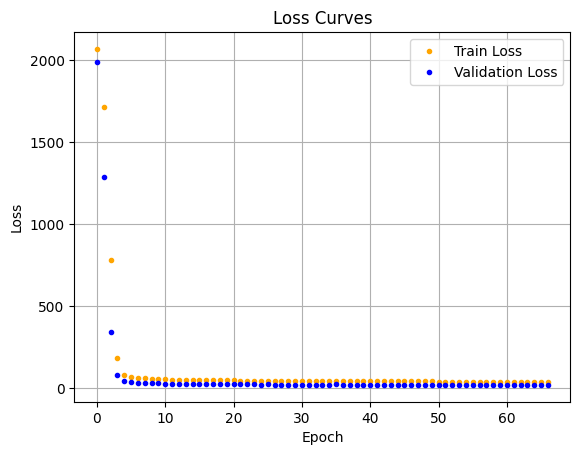


Epoch 67
---------


Train Loss: 36.9795 -|- Validation Loss: 19.2181 -|- Epoch Time: 41.7075 seconds


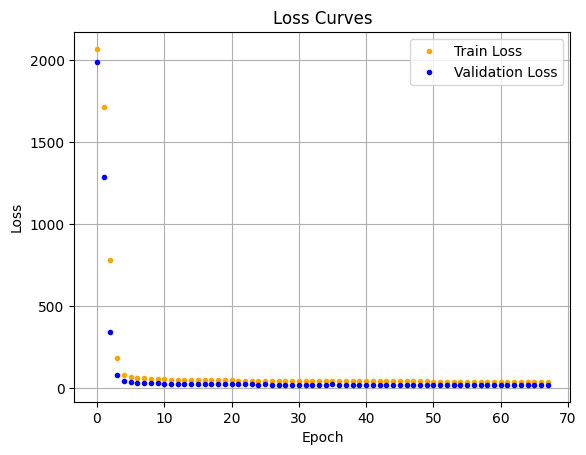


Epoch 68
---------


Train Loss: 37.2027 -|- Validation Loss: 18.3749 -|- Epoch Time: 41.7093 seconds


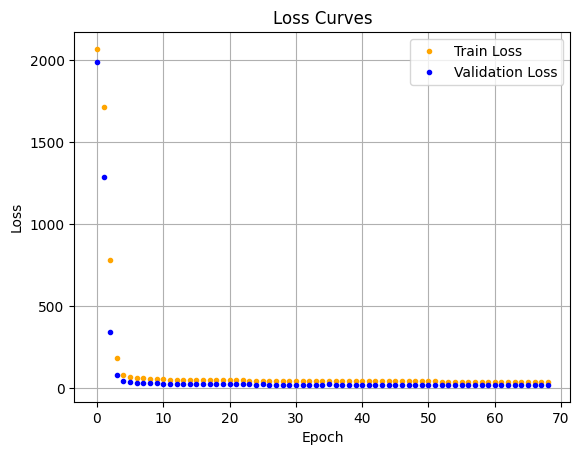


Epoch 69
---------


Train Loss: 37.0050 -|- Validation Loss: 18.8662 -|- Epoch Time: 41.7110 seconds


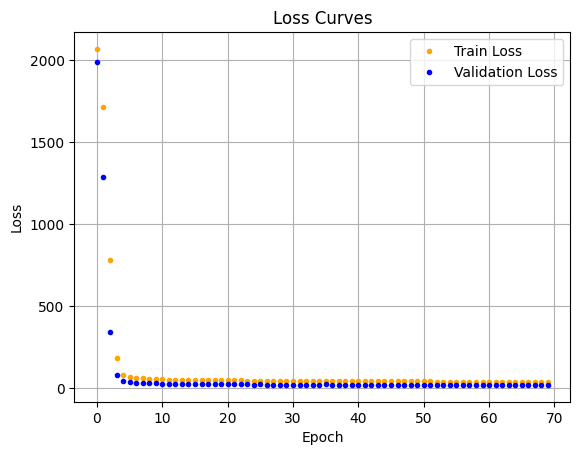


Epoch 70
---------


Train Loss: 36.3415 -|- Validation Loss: 18.7434 -|- Epoch Time: 41.7239 seconds


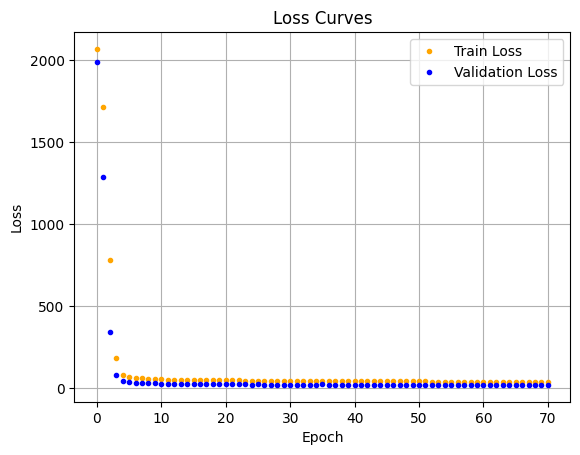


Epoch 71
---------


Train Loss: 36.3136 -|- Validation Loss: 19.2505 -|- Epoch Time: 41.7144 seconds


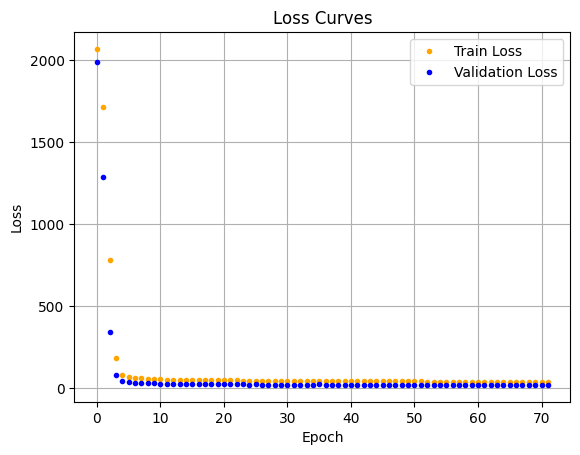


Epoch 72
---------


Train Loss: 36.1757 -|- Validation Loss: 19.2142 -|- Epoch Time: 41.7178 seconds


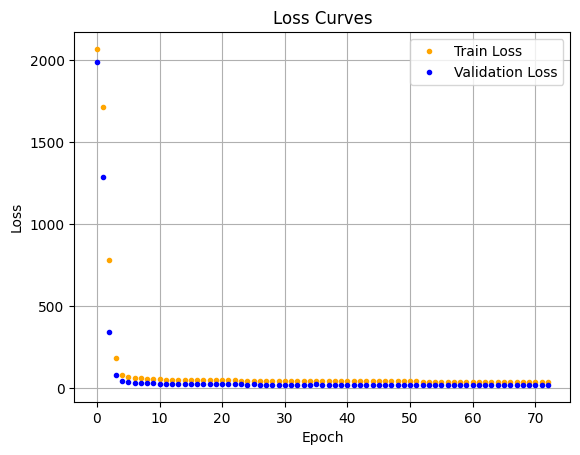


Epoch 73
---------


Train Loss: 35.8091 -|- Validation Loss: 18.7661 -|- Epoch Time: 41.7394 seconds


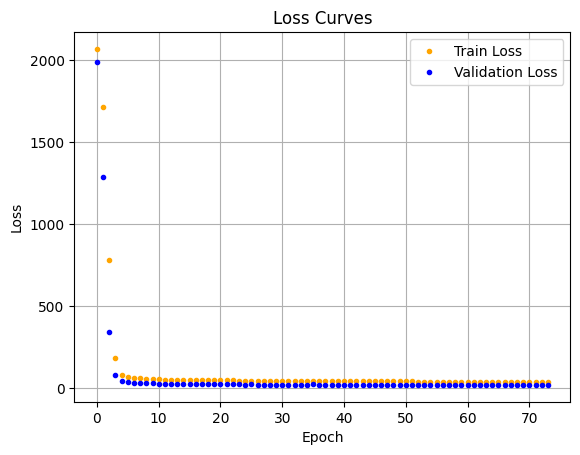


Epoch 74
---------


Train Loss: 36.2385 -|- Validation Loss: 18.8112 -|- Epoch Time: 41.7102 seconds


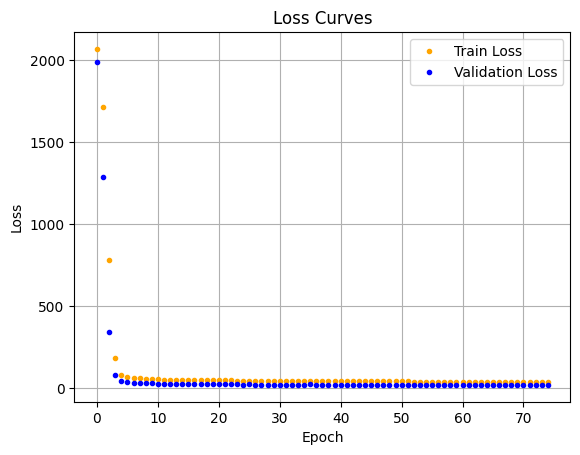


Epoch 75
---------


Train Loss: 36.1141 -|- Validation Loss: 19.2053 -|- Epoch Time: 41.7185 seconds


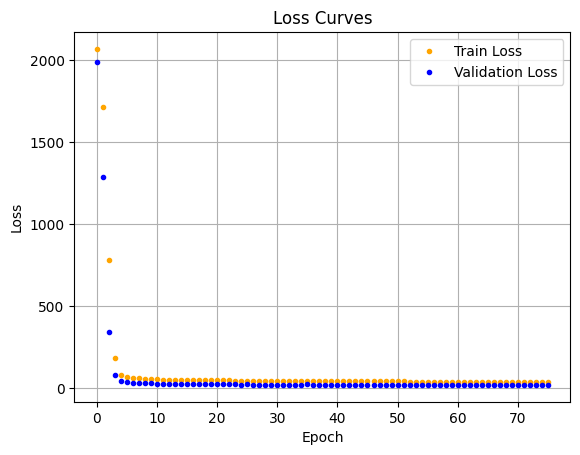


Epoch 76
---------


Train Loss: 35.6268 -|- Validation Loss: 19.2912 -|- Epoch Time: 41.6947 seconds


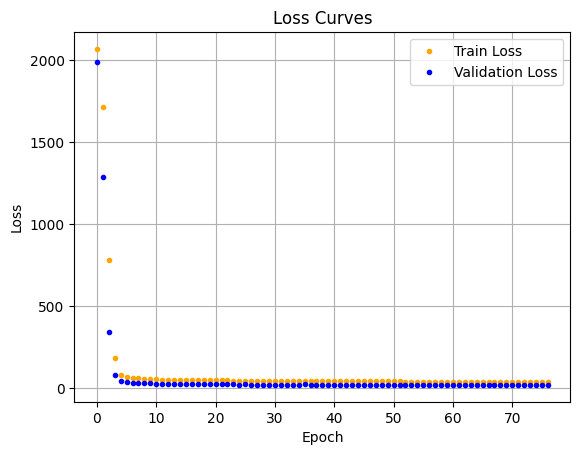


Epoch 77
---------


Train Loss: 35.5624 -|- Validation Loss: 19.0310 -|- Epoch Time: 41.7023 seconds


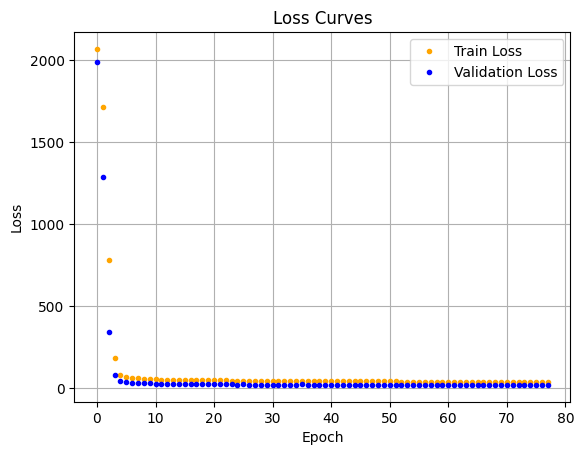


Epoch 78
---------


Train Loss: 35.3427 -|- Validation Loss: 18.6757 -|- Epoch Time: 41.7293 seconds


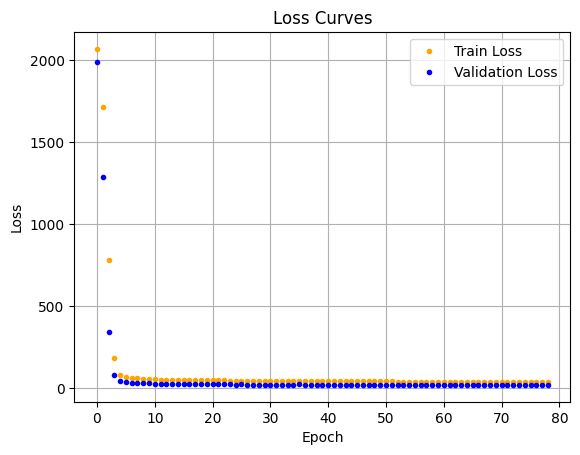


Epoch 79
---------


Train Loss: 35.6480 -|- Validation Loss: 18.5139 -|- Epoch Time: 41.7062 seconds


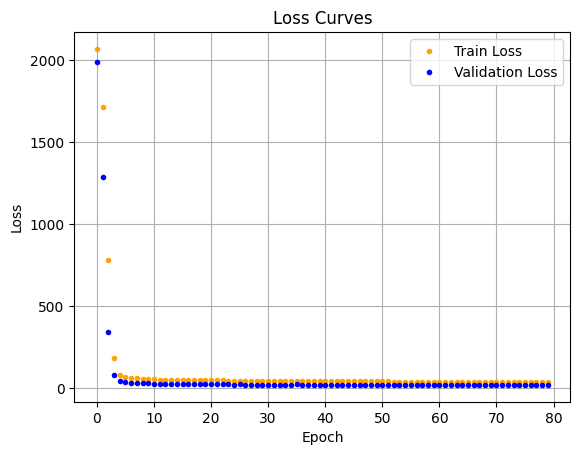


Epoch 80
---------


Train Loss: 35.0677 -|- Validation Loss: 18.9059 -|- Epoch Time: 41.6911 seconds


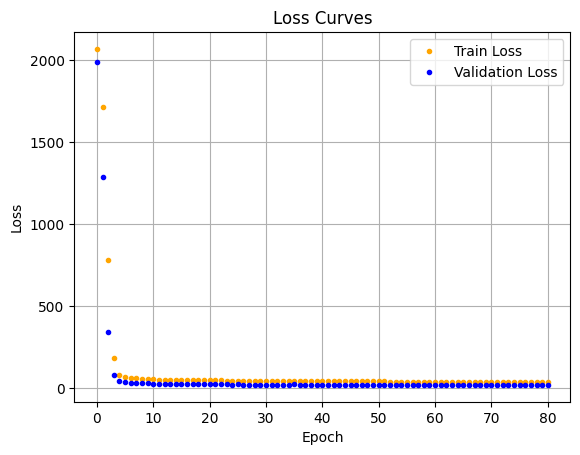


Epoch 81
---------


Train Loss: 34.9764 -|- Validation Loss: 18.7538 -|- Epoch Time: 41.6935 seconds


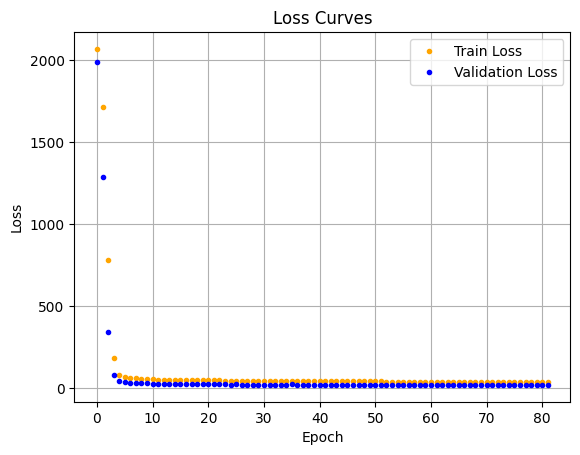


Epoch 82
---------


Train Loss: 35.2626 -|- Validation Loss: 18.7254 -|- Epoch Time: 41.8324 seconds


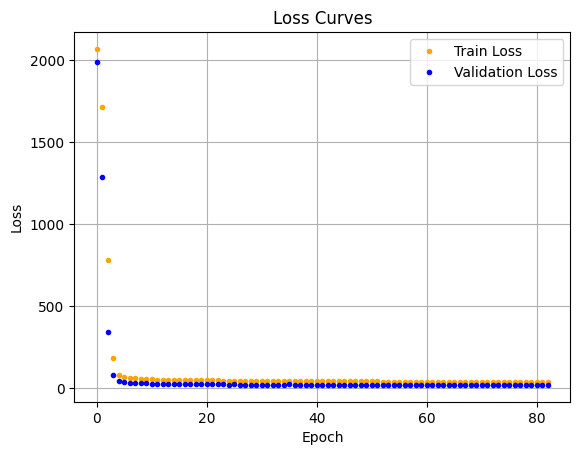


Epoch 83
---------


Train Loss: 34.8721 -|- Validation Loss: 18.9490 -|- Epoch Time: 42.4327 seconds


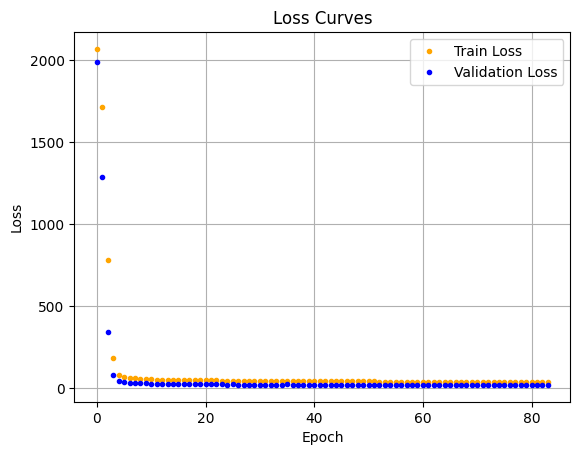


Epoch 84
---------


Train Loss: 34.7229 -|- Validation Loss: 18.3007 -|- Epoch Time: 42.4192 seconds


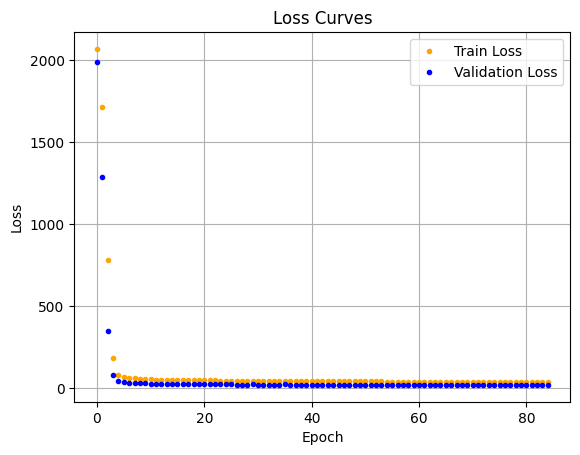


Epoch 85
---------


Train Loss: 34.7526 -|- Validation Loss: 18.9083 -|- Epoch Time: 42.3942 seconds


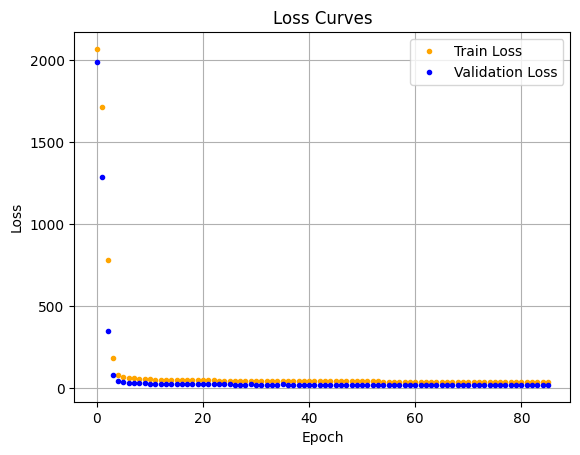


Epoch 86
---------


Train Loss: 34.4969 -|- Validation Loss: 18.4667 -|- Epoch Time: 42.4291 seconds


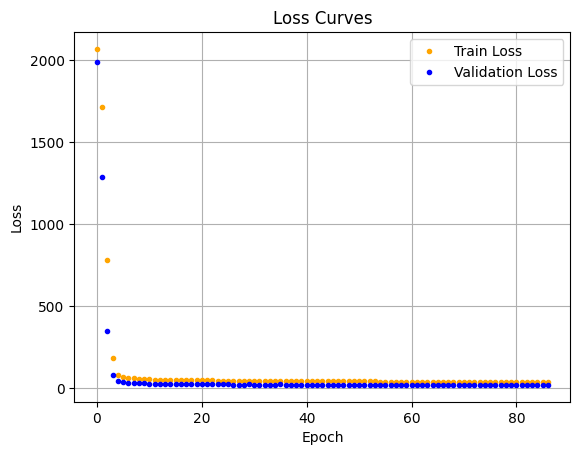


Epoch 87
---------


Train Loss: 34.4219 -|- Validation Loss: 19.3555 -|- Epoch Time: 42.3599 seconds


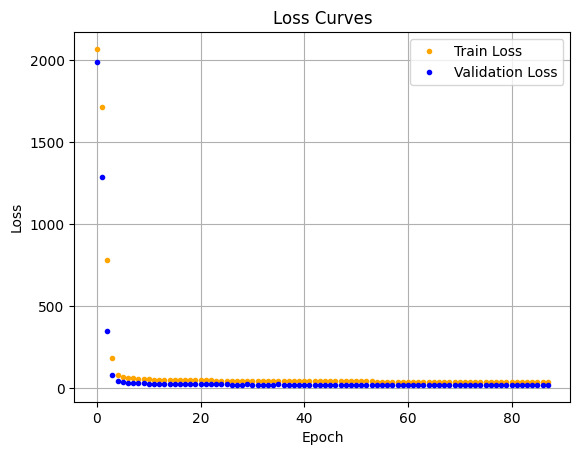


Epoch 88
---------


Train Loss: 34.2838 -|- Validation Loss: 19.0808 -|- Epoch Time: 41.7507 seconds


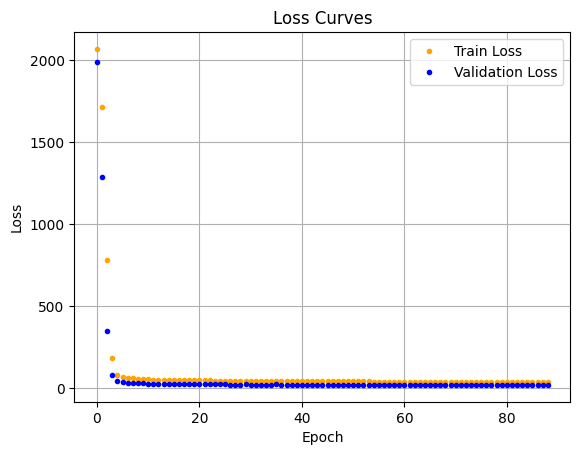


Epoch 89
---------


Train Loss: 33.9701 -|- Validation Loss: 19.2287 -|- Epoch Time: 41.7781 seconds


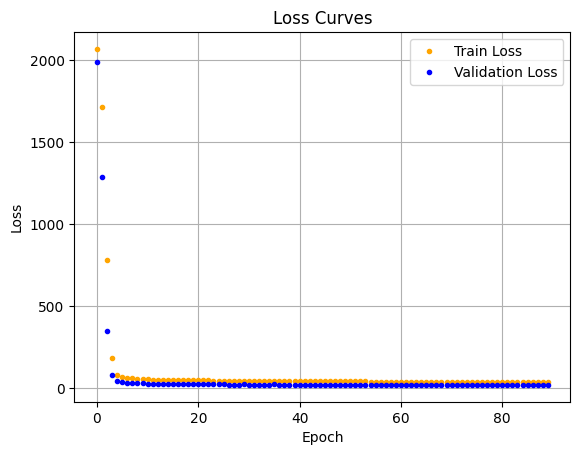


Epoch 90
---------


Train Loss: 33.8480 -|- Validation Loss: 19.0828 -|- Epoch Time: 41.7820 seconds


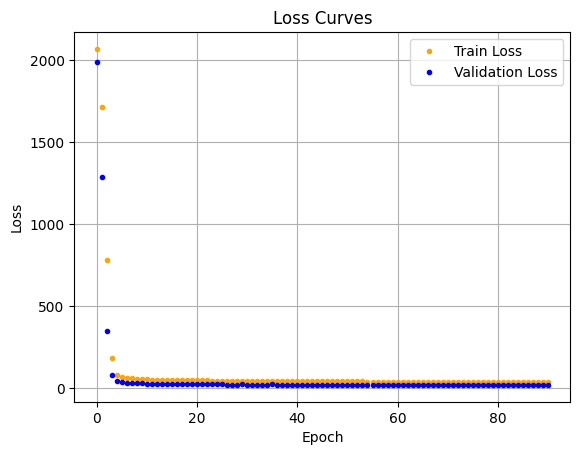


Epoch 91
---------


Train Loss: 34.1359 -|- Validation Loss: 19.0248 -|- Epoch Time: 41.8218 seconds


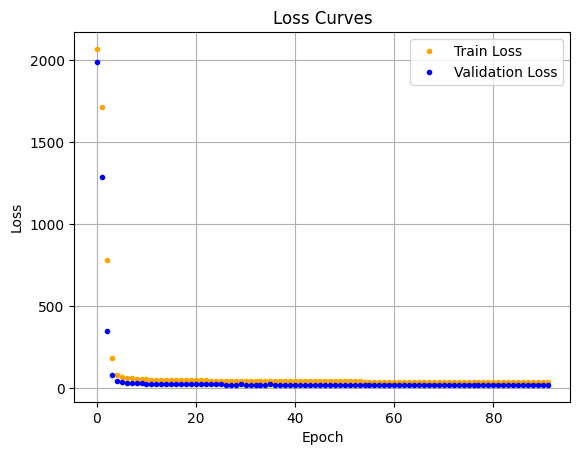


Epoch 92
---------


Train Loss: 33.6483 -|- Validation Loss: 19.1027 -|- Epoch Time: 41.8001 seconds


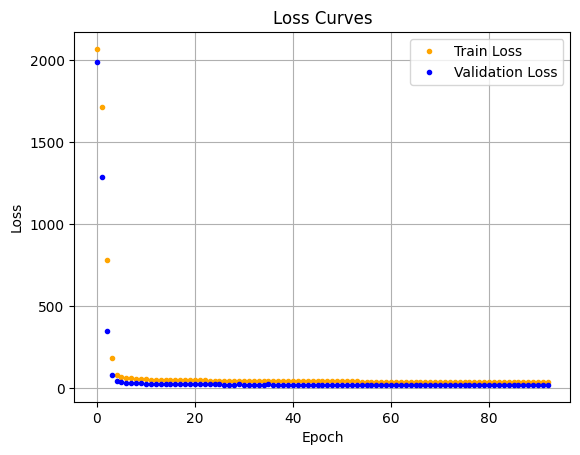


Epoch 93
---------


Train Loss: 33.7407 -|- Validation Loss: 18.3811 -|- Epoch Time: 41.7920 seconds


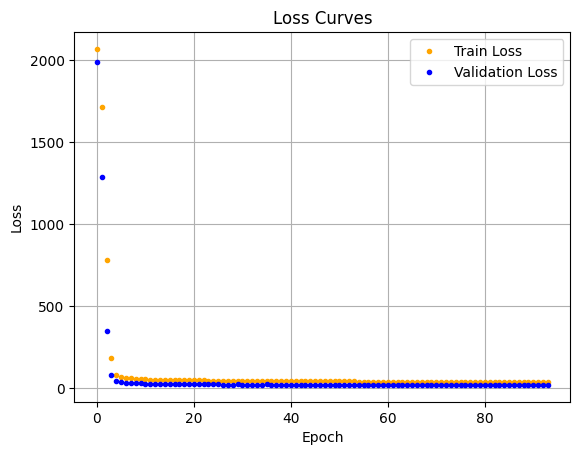


Epoch 94
---------


Train Loss: 33.8184 -|- Validation Loss: 18.7687 -|- Epoch Time: 41.7876 seconds


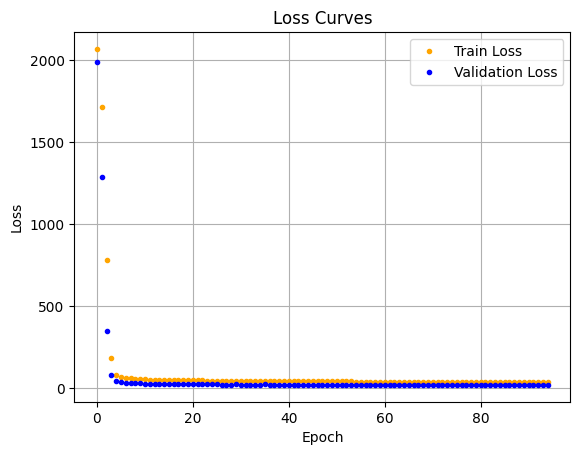


Epoch 95
---------


Train Loss: 33.7906 -|- Validation Loss: 18.8819 -|- Epoch Time: 41.8103 seconds


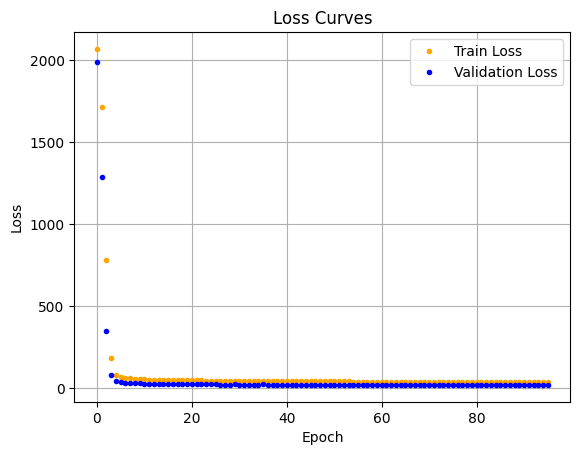


Epoch 96
---------


Train Loss: 33.2721 -|- Validation Loss: 19.6002 -|- Epoch Time: 41.8434 seconds


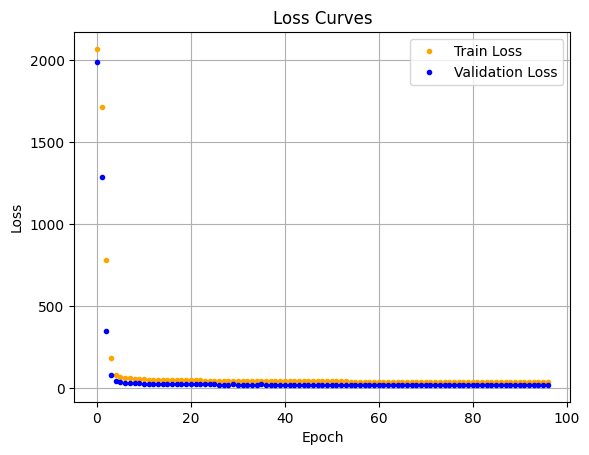


Epoch 97
---------


Train Loss: 33.2804 -|- Validation Loss: 18.5467 -|- Epoch Time: 41.8378 seconds


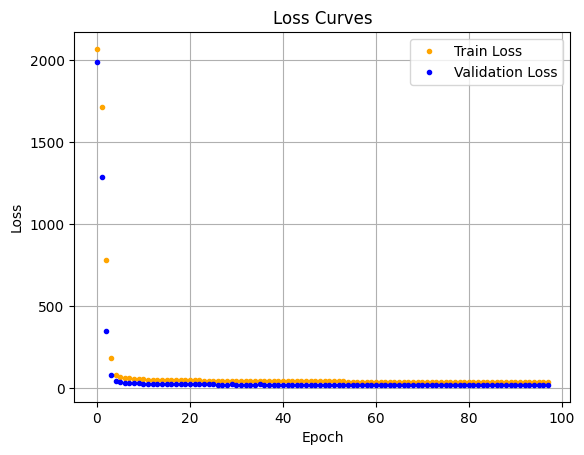


Epoch 98
---------


Train Loss: 33.0364 -|- Validation Loss: 18.7078 -|- Epoch Time: 41.8367 seconds


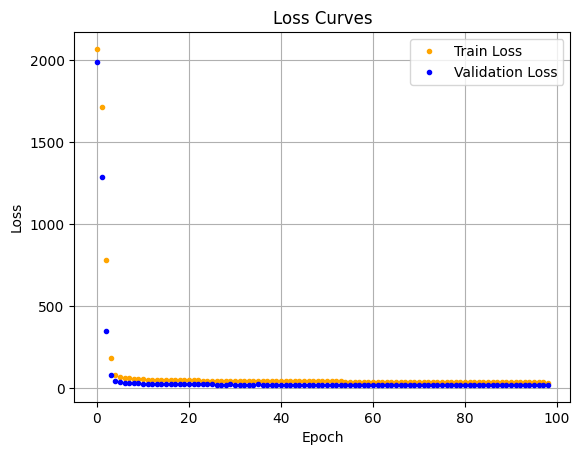


Epoch 99
---------


Train Loss: 33.3116 -|- Validation Loss: 18.9582 -|- Epoch Time: 41.8302 seconds


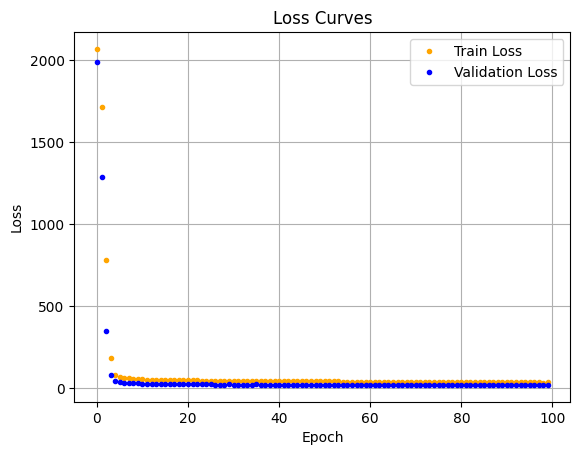

In [9]:
import numpy as np
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

model = model.to('cuda')

train_loss_list = np.array([])
val_loss_list = np.array([])

for ix_epoch in range(100):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, model, loss_function, optimizer, device='cuda')
    validation_loss = validate_model(val_loader, model, loss_function, device='cuda')
    end = time.time()
    epoch_time = end - start
    train_loss_list = np.append(train_loss_list, train_loss)
    val_loss_list = np.append(val_loss_list, validation_loss)
    print(f'Train Loss: {train_loss:0.4f} -|- Validation Loss: {validation_loss:0.4f} -|- Epoch Time: {epoch_time:0.4f} seconds')
    plt.plot(range(len(train_loss_list)),train_loss_list, '.', c='orange', label='Train Loss')
    plt.plot(range(len(train_loss_list)),val_loss_list, '.', c='blue', label='Validation Loss')
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()
    print()

In [3]:
# Save the entire model (not recommended for production)
model = torch.load('Models/Model_1_Final.pth')

/tmp/ipykernel_212994/4145871785.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('Models/Model_1_Final.pth')


R² Score: 0.9445


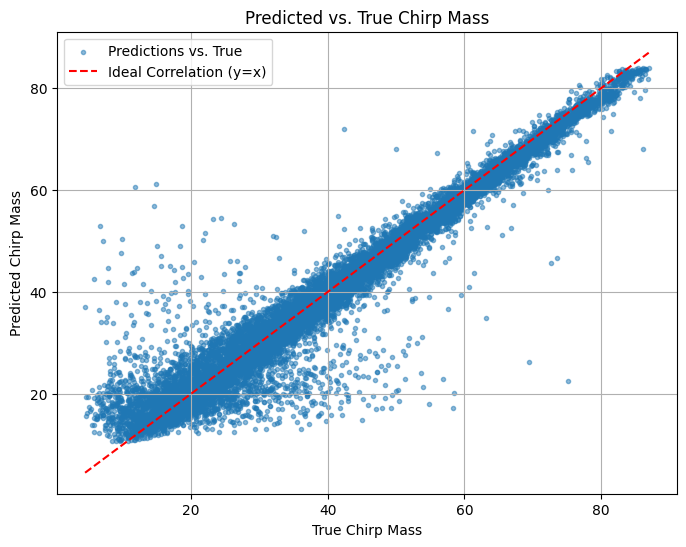

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Set model to evaluation mode
model.eval()

# Store results
predictions = []
true_labels = []

# Disable gradients for evaluation
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to('cuda'), y_test.to('cuda')

        # Get predictions
        outputs = model(X_test)

        # Store predictions and true labels
        predictions.append(outputs.cpu().numpy())
        true_labels.append(y_test.cpu().numpy())

# Convert lists to numpy arrays
predictions = np.concatenate(predictions, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

# Calculate and plot the R^2
r2 = r2_score(true_labels, predictions)
print(f"R² Score: {r2:.4f}")

# --- PLOTTING ---
plt.figure(figsize=(8, 6))
plt.scatter(true_labels, predictions, marker='.', alpha=0.5, label="Predictions vs. True")
plt.plot([min(true_labels), max(true_labels)], [min(true_labels), max(true_labels)], 'r--', label="Ideal Correlation (y=x)")
plt.xlabel("True Chirp Mass")
plt.ylabel("Predicted Chirp Mass")
plt.title("Predicted vs. True Chirp Mass")
plt.legend()
plt.grid(True)
plt.savefig("Final_Media/Model_1_Final_Performance.png")
plt.show()

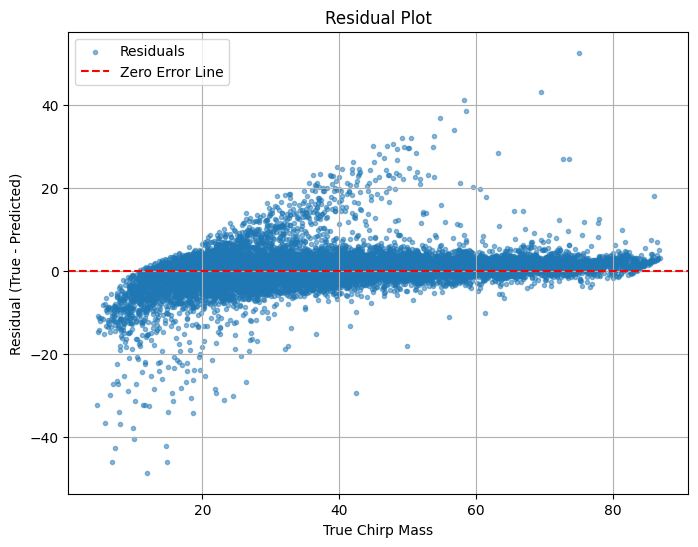

In [13]:
residuals = true_labels - predictions

plt.figure(figsize=(8, 6))
plt.scatter(true_labels, residuals, marker='.', alpha=0.5, label="Residuals")
plt.axhline(y=0, color='r', linestyle='--', label="Zero Error Line")
plt.xlabel("True Chirp Mass")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residual Plot")
plt.legend()
plt.grid(True)
plt.savefig('Final_Media/Model_1_Final_Performance_Residual.png')
plt.show()

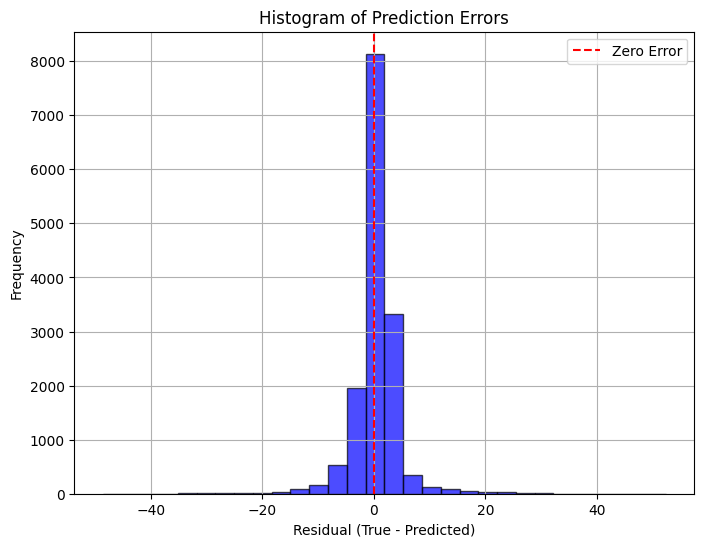

In [14]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', label="Zero Error")
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.title("Histogram of Prediction Errors")
plt.legend()
plt.grid(True)
plt.savefig('Final_Media/Model_1_Final_Performance_Residual_Histogram.png')
plt.show()

In [17]:
average = np.mean(residuals)
stdev = np.std(residuals)
average, stdev

(np.float32(0.4759243), np.float32(4.378222))